# Retrieve Analogy Label Correlation

In [26]:
from os import listdir
from os.path import isfile, join
import json

## Loading all labeled data

In [27]:
results_path = "results/analogy_labels/annotated_human_analogies_gpt-4.txt"
human_labels = {}

def read_labels_from_file(data, path):
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 4:  # Ensure the expected format
                continue
            key = parts[0]
            values_0 = parts[1].split(", ") if parts[1] else []
            values_1 = parts[2].split(" ||| ") if parts[2] else []
            values_2 = parts[3].split(", ") if parts[3] else []
            data[key] = [values_1, values_2] # included values_0 as first entry

read_labels_from_file(human_labels, results_path)

In [28]:
human_labels

{'wanted': [['circle wants square. as circle is first its on the left, furthermore the arrow should point towards the square as it shows circle acting towards square',
   'The arrow to the right elicits something like pursuit - circle wants square so circle goes and gets it. D feels similar, but more causal.  ',
   "The arrow pointing from the circle to the square indicates the circle 'needing' the square, and the left to right follows a logical timeline/direction of thought.",
   'When you want something you move towards it, hence an arrow towards the thing you want. Preferably horizontally as gravity complicates the analogy.',
   'The arrow originating from the circle designates desire.',
   'Because the circle moved to the object it "wanted\', it takes the action. however C and D seem to represent the same as A',
   'An arrow is like pointing to something. Image A is like a child pointing to something it wants.',
   'Wanting is active state of desire or attraction towards something 

In [29]:
path_to_llm_results = "results/llms/"

model_paths = ["gpt" , "llama", "reasoning"] 

files_per_model = {}
for model_path in model_paths:

    files = [f for f in listdir(path_to_llm_results+model_path) if isfile(join(path_to_llm_results+model_path, f))]
    relevant_files = [f for f in files if f.startswith("generated") and f.endswith("analogy.txt") and "70b_refl" not in f]
    relevant_files.extend([f for f in files if f.startswith("generated") and model_path=="zeroshot" and "70b_refl" not in f])
    

    files_per_model[model_path] = relevant_files

print(files_per_model)

{'gpt': ['generated_answers_pseudo_4-mini_analogy.txt', 'generated_answers_text_4-mini_analogy.txt', 'generated_answers_pseudo_4_analogy.txt', 'generated_answers_text_4_analogy.txt', 'generated_answers_text_3.5_analogy.txt', 'generated_answers_pseudo_3.5_analogy.txt'], 'llama': ['generated_answers_text_70b_analogy.txt', 'generated_answers_text_r1-llama_analogy.txt', 'generated_answers_pseudo_70b_inst_analogy.txt', 'generated_answers_pseudo_70b_analogy.txt', 'generated_answers_text_70b_inst_analogy.txt', 'generated_answers_pseudo_r1-llama_analogy.txt'], 'reasoning': ['generated_answers_pseudo_o1-preview_analogy.txt', 'generated_answers_text_o1-preview_analogy.txt']}


In [30]:
llm_labels = {}

for model_name, file_names in files_per_model.items():
    llm_labels[model_name] = {} 

    for file_name in file_names:
        condition = file_name.replace("generated_answers_","").replace("_analogy.txt","")
        llm_labels[model_name][condition] = {}


        label_out_path = f"results/analogy_labels/annotated_model_analogies_{model_name}_{condition}.txt"
        with open(label_out_path, "r") as f:

            for line in f.readlines():
                parts = line.strip().split("\t")
                key = parts[0]
                values_1 = parts[1].split(" ||| ") if parts[1] else []
                values_2 = parts[2].split(", ") if parts[2] else []

                
                llm_labels[model_name][condition][key] = [values_1, values_2]

In [31]:
llm_labels['gpt']['text_4']

{'fled': [["'Fleeing' often involves moving away quickly from a particular point or situation, typically in a direction that leads to safety or escape. In many contexts, 'up' can symbolize moving away or ascending to a higher, safer place, as in climbing to escape danger or rising above a threat.",
   "'Fleeing' often involves moving away quickly from a situation or location, typically in a direction that leads to safety or escape. In many contexts, when someone flees, they are moving away from a threat or danger, often in a direction that is opposite to where the threat is coming from. In a spatial sense, 'up' can represent moving away or ascending to a higher, safer place, but 'down' can also imply moving away or descending to escape. However, 'right' and 'left' are more lateral movements, which can also represent fleeing but are less commonly associated with the idea of escaping upwards or downwards.",
   "'Fleeing' often involves moving away quickly from a situation or location, ty

In [32]:
action_words = list(llm_labels['gpt']['text_4'].keys())

In [33]:
path_to_vlm_results = "results/vlms/parsed_results/"

model_paths = ["molmo" , "qwen-vl"] 

files_per_model = {}
for model_path in model_paths:

    files = [f for f in listdir(path_to_vlm_results) if isfile(join(path_to_vlm_results, f))]
    relevant_files = [f for f in files if f.endswith("analogies.json") and f.startswith(model_path)]
    files_per_model[model_path] = relevant_files

print(files_per_model)

{'molmo': ['molmo72b-human-analogies.json', 'molmo-human-analogies.json'], 'qwen-vl': ['qwen-vl-human-analogies.json', 'qwen-vl-72b-human-analogies.json']}


In [34]:
vlm_labels = {}

for model_name, file_names in files_per_model.items():
    vlm_labels[model_name] = {}
    for file in file_names:
        label_out_path = f"results/analogy_labels/annotated_model_analogies_{file}".replace("-human-analogies.json",".txt").replace(model_name,model_name+"_")
        size = label_out_path.split("_")[-1].replace(".txt","")
        # fixing inconsitent naming
        if not size: size = "7b"
        vlm_labels[model_name][size] = {}
        
        label_out_path = label_out_path.replace("o_.t", "o_7b.t").replace("l_.t", "l_7b.t").replace("-7","7") # manually fixing inconsistent naming
        with open(label_out_path, "r") as f:

            reformed_lines = []
            current_line = ""
            for line in f.readlines():
                if line.startswith(tuple(action_words)):
                    if current_line != "":
                        reformed_lines.append(current_line)
                        current_line = line
                    else: 
                        current_line += line
                else:
                    current_line += line
            reformed_lines.append(current_line)
            
            for line in reformed_lines:
                parts = line.strip().split("\t")
                key = parts[0]
                values_1 = parts[1].split(" ||| ") if parts[1] else []
                values_2 = parts[2].split(", ") if parts[2] else []


                
                vlm_labels[model_name][size][key] = [values_1, values_2]

In [35]:
vlm_labels['qwen-vl']['7b']

{'fled': [["'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone. A person running away from a danger or threat is a common visual representation of this action.",
   "'Fled' implies moving away from something or someone

## Analysis of Correlations

In [36]:
from collections import Counter
from scipy.stats import spearmanr

CATEGORIES = ["Physical Action", "Directional Metaphor", "Cultural/Convention", "Interactive Entities", "No Analogy/Explanation"]

# Function to compute frequency vector for a list of labels based on CATEGORIES.
def get_freq_vector(labels_list, categories):
    # count the occurrences of each category;
    # note: we use counts (not proportions). If you prefer proportions, simply divide each count by len(labels_list)
    counter = Counter(labels_list)
    # produce frequency vector in the order of categories
    return [counter.get(cat, 0) for cat in categories]

# Function to compute per-category F1 score and average them (macro F1)
def compute_macro_f1(human_counts, model_counts):
    f1_scores = []
    for h, m in zip(human_counts, model_counts):
        if h + m == 0:
            # if both are zero, we can define an F1 of 1 (perfect agreement for that category)
            f1 = 1.0
        else:
            # true positives: assuming the best we can say is min(h, m)
            tp = min(h, m)
            f1 = (2 * tp) / (h + m)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores)

# Function to process one set (llm or vlm) of models.
def process_model_labels(model_labels, human_labels, categories):
    # This function loops over each model name and each condition, then per word computes:
    #   • frequency vectors for human responses (8 responses per word)
    #   • frequency vectors for model responses (24 responses per word)
    #   • Spearman rank correlation, and macro F1 score as defined
    results = {}  # structure: results[model_name][condition][word] = {"spearman": val, "f1": val}
    
    for model_name, conditions in model_labels.items():
        results.setdefault(model_name, {})
        for condition, words_dict in conditions.items():
            results[model_name].setdefault(condition, {})
            # Loop through words. We assume words are the same as in human_labels.
            for word, data in words_dict.items():
                # data is a list: [analogies, labels]. We only work with labels.
                model_labels_list = data[1]  # 24 responses per word
                # human labels for the same word: list of 8 responses from human_labels.
                human_labels_list = human_labels[word][1]
                
                # Get counts (frequency vector for each category in the order of CATEGORIES)
                human_freqs = get_freq_vector(human_labels_list, categories)
                model_freqs = get_freq_vector(model_labels_list, categories)
                
                # Compute Spearman rank correlation. Use try/except in case of constant arrays.
                try:
                    rho, _ = spearmanr(human_freqs, model_freqs)
                    # If spearmanr returns nan (if one array is constant), then set rho = 0.0
                    if rho != rho:
                        rho = 0.0
                except Exception as e:
                    rho = 0.0
                    
                # Compute the macro F1 score (averaged over the 4 categories).
                macro_f1 = compute_macro_f1(human_freqs, model_freqs)
                
                # Store the results.
                results[model_name][condition][word] = {"spearman": rho, "f1": macro_f1}
    return results


# Process LLM labels versus humans:
llm_results = process_model_labels(llm_labels, human_labels, CATEGORIES)

# Process VLM labels versus humans:
vlm_results = process_model_labels(vlm_labels, human_labels, CATEGORIES)

# Example: Aggregate average metrics per condition for LLM "gpt"
import numpy as np
for condition, words_dict in llm_results.get("gpt", {}).items():
    spearman_vals = []
    f1_vals = []
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    print(f'LLM "gpt" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}, Average F1: {avg_f1:.4f}')
print()
for condition, words_dict in llm_results.get("llama", {}).items():
    spearman_vals = []
    f1_vals = []
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    print(f'LLM "llama" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}, Average F1: {avg_f1:.4f}')
print()
for condition, words_dict in vlm_results.get("molmo", {}).items():
    spearman_vals = []
    f1_vals = []
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    print(f'VLM "molmo" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}, Average F1: {avg_f1:.4f}')
print()
for condition, words_dict in vlm_results.get("qwen-vl", {}).items():
    spearman_vals = []
    f1_vals = []
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    print(f'VLM "qwen-vl" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}, Average F1: {avg_f1:.4f}')

LLM "gpt" condition "pseudo_4-mini" ==> Average Spearman: 0.1404, Average F1: 0.4006
LLM "gpt" condition "text_4-mini" ==> Average Spearman: 0.1230, Average F1: 0.3913
LLM "gpt" condition "pseudo_4" ==> Average Spearman: 0.1380, Average F1: 0.4099
LLM "gpt" condition "text_4" ==> Average Spearman: 0.1159, Average F1: 0.4055
LLM "gpt" condition "text_3.5" ==> Average Spearman: 0.1658, Average F1: 0.4251
LLM "gpt" condition "pseudo_3.5" ==> Average Spearman: 0.1439, Average F1: 0.4240

LLM "llama" condition "text_70b" ==> Average Spearman: 0.1561, Average F1: 0.4298
LLM "llama" condition "text_r1-llama" ==> Average Spearman: 0.1405, Average F1: 0.4172
LLM "llama" condition "pseudo_70b_inst" ==> Average Spearman: 0.1985, Average F1: 0.4264
LLM "llama" condition "pseudo_70b" ==> Average Spearman: 0.1570, Average F1: 0.4081
LLM "llama" condition "text_70b_inst" ==> Average Spearman: 0.1660, Average F1: 0.4258
LLM "llama" condition "pseudo_r1-llama" ==> Average Spearman: 0.1374, Average F1: 

In [37]:
from collections import Counter
from scipy.stats import spearmanr
import numpy as np

CATEGORIES = ["Physical Action", "Directional Metaphor", "Cultural/Convention", "Interactive Entities", "No Analogy/Explanation"]

# Function to compute frequency vector for a list of labels based on CATEGORIES.
def get_freq_vector(labels_list, categories):
    counter = Counter(labels_list)
    return [counter.get(cat, 0) for cat in categories]

# Function to compute per-category F1 score and average them (macro F1)
def compute_macro_f1(human_counts, model_counts):
    f1_scores = []
    for h, m in zip(human_counts, model_counts):
        if h + m == 0:
            f1 = 1.0
        else:
            tp = min(h, m)
            f1 = (2 * tp) / (h + m)
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores)

# Function to process one set (llm or vlm) of models.
def process_model_labels(model_labels, human_labels, categories):
    # Structure: results[model_name][condition][word] = {"spearman": val, "p_val": val, "f1": val}
    results = {}
    
    for model_name, conditions in model_labels.items():
        results.setdefault(model_name, {})
        for condition, words_dict in conditions.items():
            results[model_name].setdefault(condition, {})
            for word, data in words_dict.items():
                # data is a list: [analogies, labels]. We only work with labels.
                model_labels_list = data[1]  # 24 responses per word
                human_labels_list = human_labels[word][1]  # 8 responses per word
                
                # Get frequency vectors.
                human_freqs = get_freq_vector(human_labels_list, categories)
                model_freqs = get_freq_vector(model_labels_list, categories)
                
                # Compute Spearman correlation and get its p-value.
                try:
                    rho, p_val = spearmanr(human_freqs, model_freqs)
                    # Handle nan (which can occur if one array is constant).
                    if rho != rho:  # or np.isnan(rho)
                        rho = 0.0
                        p_val = 1.0
                except Exception as e:
                    rho = 0.0
                    p_val = 1.0
                
                # Compute macro F1 score.
                macro_f1 = compute_macro_f1(human_freqs, model_freqs)
                
                # Store the results, including p-value.
                results[model_name][condition][word] = {"spearman": rho, "p_val": p_val, "f1": macro_f1}
    return results

# Assume llm_labels and vlm_labels (and human_labels) are defined.
# Process LLM and VLM labels versus humans:
llm_results = process_model_labels(llm_labels, human_labels, CATEGORIES)
vlm_results = process_model_labels(vlm_labels, human_labels, CATEGORIES)

# Define significance threshold.
sig_threshold = 0.05

# Example: Aggregate average metrics per condition for LLM "gpt"
for condition, words_dict in llm_results.get("gpt", {}).items():
    spearman_vals = []
    f1_vals = []
    sig_count = 0
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
        if metrics["p_val"] < sig_threshold:
            sig_count += 1
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    # If at least half of the word-level correlations are significant, add a star.
    sig_flag = "*" if (sig_count / len(words_dict)) >= 0.5 else ""
    print(f'LLM "gpt" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}{sig_flag}, Average F1: {avg_f1:.4f}')
print()

for condition, words_dict in llm_results.get("llama", {}).items():
    spearman_vals = []
    f1_vals = []
    sig_count = 0
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
        if metrics["p_val"] < sig_threshold:
            sig_count += 1
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    sig_flag = "*" if (sig_count / len(words_dict)) >= 0.5 else ""
    print(f'LLM "llama" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}{sig_flag}, Average F1: {avg_f1:.4f}')
print()

for condition, words_dict in vlm_results.get("molmo", {}).items():
    spearman_vals = []
    f1_vals = []
    sig_count = 0
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
        if metrics["p_val"] < sig_threshold:
            sig_count += 1
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    sig_flag = "*" if (sig_count / len(words_dict)) >= 0.5 else ""
    print(f'VLM "molmo" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}{sig_flag}, Average F1: {avg_f1:.4f}')
print()

for condition, words_dict in vlm_results.get("qwen-vl", {}).items():
    spearman_vals = []
    f1_vals = []
    sig_count = 0
    for word, metrics in words_dict.items():
        spearman_vals.append(metrics["spearman"])
        f1_vals.append(metrics["f1"])
        if metrics["p_val"] < sig_threshold:
            print("SIGNIFICANT CORRELATION")
            sig_count += 1
    avg_spearman = np.mean(spearman_vals)
    avg_f1 = np.mean(f1_vals)
    sig_flag = "*" if (sig_count / len(words_dict)) >= 0.5 else ""
    print(f'VLM "qwen-vl" condition "{condition}" ==> Average Spearman: {avg_spearman:.4f}{sig_flag}, Average F1: {avg_f1:.4f}')


LLM "gpt" condition "pseudo_4-mini" ==> Average Spearman: 0.1404, Average F1: 0.4006
LLM "gpt" condition "text_4-mini" ==> Average Spearman: 0.1230, Average F1: 0.3913
LLM "gpt" condition "pseudo_4" ==> Average Spearman: 0.1380, Average F1: 0.4099
LLM "gpt" condition "text_4" ==> Average Spearman: 0.1159, Average F1: 0.4055
LLM "gpt" condition "text_3.5" ==> Average Spearman: 0.1658, Average F1: 0.4251
LLM "gpt" condition "pseudo_3.5" ==> Average Spearman: 0.1439, Average F1: 0.4240

LLM "llama" condition "text_70b" ==> Average Spearman: 0.1561, Average F1: 0.4298
LLM "llama" condition "text_r1-llama" ==> Average Spearman: 0.1405, Average F1: 0.4172
LLM "llama" condition "pseudo_70b_inst" ==> Average Spearman: 0.1985, Average F1: 0.4264
LLM "llama" condition "pseudo_70b" ==> Average Spearman: 0.1570, Average F1: 0.4081
LLM "llama" condition "text_70b_inst" ==> Average Spearman: 0.1660, Average F1: 0.4258
LLM "llama" condition "pseudo_r1-llama" ==> Average Spearman: 0.1374, Average F1: 

In [38]:
import json
import numpy as np

# Function to aggregate results per model and condition
def aggregate_results(results):
    agg = {}
    for model_name, conditions in results.items():
        agg.setdefault(model_name, {})
        for condition, words in conditions.items():
            spearman_vals = [metrics["spearman"] for metrics in words.values()]
            f1_vals = [metrics["f1"] for metrics in words.values()]
            agg[model_name][condition] = {
                "average_spearman": float(np.mean(spearman_vals)),
                "average_f1": float(np.mean(f1_vals))
            }
    return agg

# Aggregate LLM and VLM results
aggregate_llm = aggregate_results(llm_results)
aggregate_vlm = aggregate_results(vlm_results)

# Structure final JSON data
final_output = {
    "LLM": aggregate_llm,
    "VLM": aggregate_vlm
}

# Save JSON to file with readable indentation
with open("results/analogy_labels/aggregated_label_evaluation.json", "w") as outfile:
    json.dump(final_output, outfile, indent=2)

In [39]:

# For example, to print the results for the LLM "gpt" under condition "pseudo_3.5":
if "gpt" in llm_results and "pseudo_3.5" in llm_results["gpt"]:
    for word, metrics in llm_results["gpt"]["pseudo_3.5"].items():
        print(f'Word: {word} ⟹ Spearman: {metrics["spearman"]:.4f} | F1: {metrics["f1"]:.4f}')


Word: fled ⟹ Spearman: 0.1250 | F1: 0.4174
Word: pointed at ⟹ Spearman: 0.3627 | F1: 0.4444
Word: pulled ⟹ Spearman: 0.3953 | F1: 0.6308
Word: pushed ⟹ Spearman: 0.3953 | F1: 0.6444
Word: walked ⟹ Spearman: 0.7906 | F1: 0.6690
Word: hunted ⟹ Spearman: -0.5441 | F1: 0.2000
Word: impacted ⟹ Spearman: 0.3627 | F1: 0.4308
Word: perched ⟹ Spearman: 0.3227 | F1: 0.4640
Word: showed ⟹ Spearman: -0.3627 | F1: 0.2160
Word: smashed ⟹ Spearman: 0.5590 | F1: 0.2444
Word: bombed ⟹ Spearman: 0.6124 | F1: 0.6571
Word: flew ⟹ Spearman: 0.3627 | F1: 0.4444
Word: floated ⟹ Spearman: 0.3953 | F1: 0.6444
Word: lifted ⟹ Spearman: 0.3227 | F1: 0.4593
Word: sank ⟹ Spearman: 0.5590 | F1: 0.4444
Word: argued with ⟹ Spearman: 0.6842 | F1: 0.5911
Word: gave to ⟹ Spearman: -0.2868 | F1: 0.3182
Word: offended ⟹ Spearman: -0.5162 | F1: 0.2400
Word: rushed ⟹ Spearman: 0.4125 | F1: 0.4462
Word: warned ⟹ Spearman: -0.3441 | F1: 0.2167
Word: owned ⟹ Spearman: 0.3441 | F1: 0.6462
Word: regretted ⟹ Spearman: -0.4125 | F1

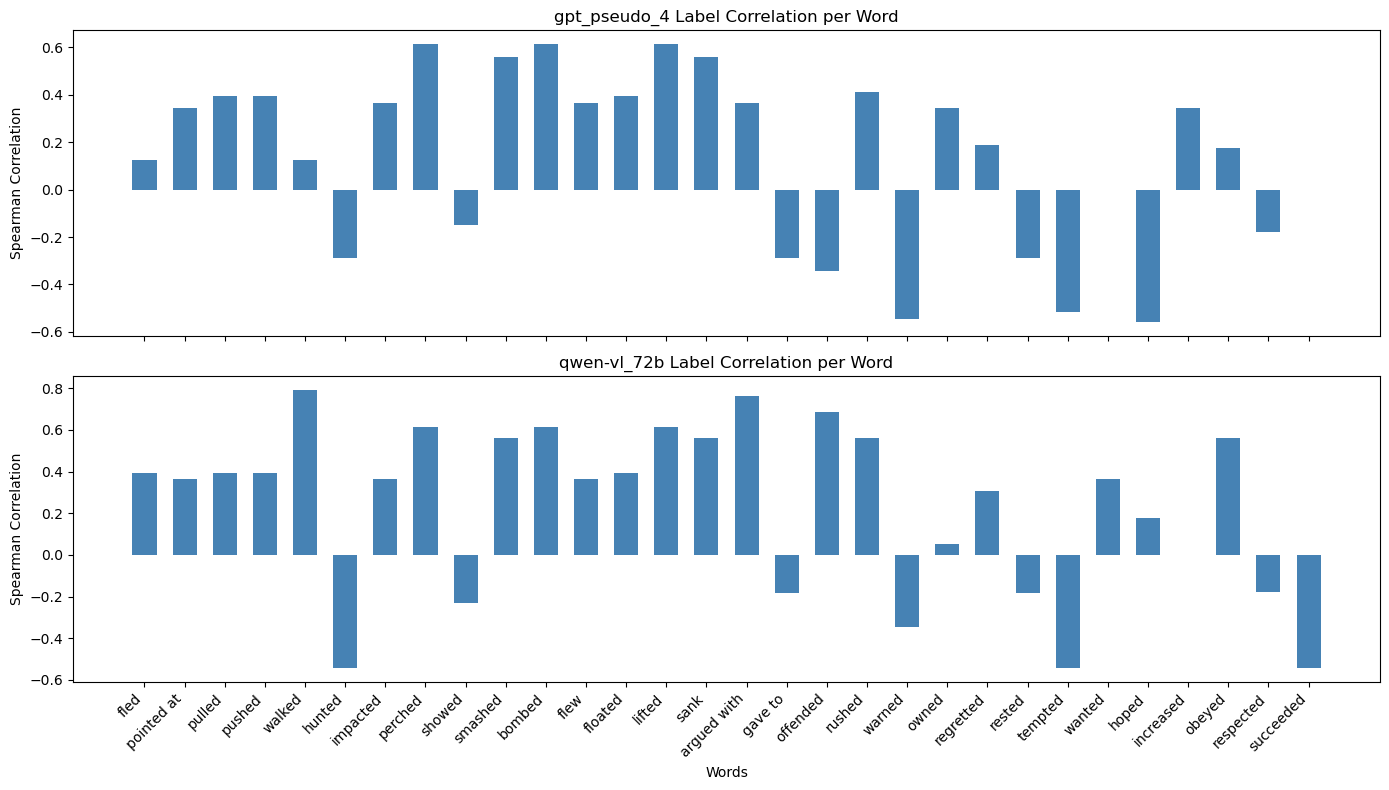

In [40]:
import matplotlib.pyplot as plt
import numpy as np


gpt_results = llm_results["gpt"]["pseudo_4"]
qwen_answers = vlm_results["qwen-vl"]["-72b"]

# Get the list of words.
words = list(gpt_results.keys())

# Extract correlation values. (For each word we expect a dict with key "spearman".)
gpt_spearman = [gpt_results[word]["spearman"] for word in words]
qwen_spearman = [qwen_answers[word]["spearman"] for word in words]

# Create a figure with two vertically stacked subplots that share the x-axis.
fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
indices = np.arange(len(words))  # positions for the bars
bar_width = 0.6  # Width of bars for a neat appearance
bar_color = "steelblue"  # muted color

# Upper plot: Showing gpt_pseudo_4 correlations (from LLM)
ax_top.bar(indices, gpt_spearman, width=bar_width, color=bar_color)
ax_top.set_ylabel("Spearman Correlation")
ax_top.set_title("gpt_pseudo_4 Label Correlation per Word")
# Hide x-axis tick labels in the upper plot.
ax_top.tick_params(axis="x", labelbottom=False)

# Lower plot: Showing qwen-vl_72b correlations (from VLM)
ax_bot.bar(indices, qwen_spearman, width=bar_width, color=bar_color)
ax_bot.set_ylabel("Spearman Correlation")
ax_bot.set_title("qwen-vl_72b Label Correlation per Word")
# Set x-axis tick labels with word names, rotated for compactness.
ax_bot.set_xticks(indices)
ax_bot.set_xticklabels(words, rotation=45, ha="right")
ax_bot.set_xlabel("Words")

plt.tight_layout()
plt.show()

In [41]:
import json

with open("results/llms/gpt/choices_pseudo_4_analogy.txt", "r") as f:
    llm_data = [line.strip() for line in f.readlines()]

with open("results/vlms/parsed_results/qwen-vl-72b-human-concepts.json", "r") as f:
    vlm_dict = json.load(f)



In [42]:
llm_dict = {}
for line in llm_data[1:-2]:
    content = line.split("\t")
    llm_dict[content[0]] = {}

    sum_choices = int(content[1])+int(content[2])+int(content[3])+int(content[4])
    llm_dict[content[0]]['up'] = round(int(content[1])/sum_choices,2)
    llm_dict[content[0]]['down'] = round(int(content[2])/sum_choices,2)
    llm_dict[content[0]]['left'] = round(int(content[3])/sum_choices,2)
    llm_dict[content[0]]['right'] = round(int(content[4])/sum_choices,2)

In [43]:
hmn_dict = {}

with open("../../data/richardson_responsesSEP.txt", "r") as f:
    lines = [line.strip() for line in f.readlines()]

for line in lines:
    content = line.split("%")
    hmn_dict[content[0]] = {}
    values = content[1].split(" ")
    hmn_dict[content[0]]['up'] = float(values[0])
    hmn_dict[content[0]]['down'] = float(values[1])
    hmn_dict[content[0]]['left'] = float(values[2])
    hmn_dict[content[0]]['right'] = float(values[3])


In [44]:
for k, v in vlm_dict.items():
    print(k, v)
    print(k, llm_dict[k])
    print(k, hmn_dict[k])
    print()

fled {'up': 0.0, 'down': 0.0, 'left': 75.0, 'right': 25.0}
fled {'up': 0.04, 'down': 0.29, 'left': 0.46, 'right': 0.21}
fled {'up': 7.2, 'down': 4.2, 'left': 80.8, 'right': 7.8}

pointed at {'up': 20.8, 'down': 4.2, 'left': 0.0, 'right': 75.0}
pointed at {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 1.0}
pointed at {'up': 7.2, 'down': 3.6, 'left': 0.0, 'right': 89.2}

pulled {'up': 16.7, 'down': 0.0, 'left': 83.3, 'right': 0.0}
pulled {'up': 0.08, 'down': 0.17, 'left': 0.75, 'right': 0.0}
pulled {'up': 6.0, 'down': 5.4, 'left': 75.4, 'right': 13.2}

pushed {'up': 4.2, 'down': 0.0, 'left': 41.7, 'right': 54.2}
pushed {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 1.0}
pushed {'up': 7.2, 'down': 3.6, 'left': 1.2, 'right': 88.0}

walked {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 100.0}
walked {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 1.0}
walked {'up': 9.0, 'down': 3.6, 'left': 24.0, 'right': 62.9}

hunted {'up': 8.3, 'down': 4.2, 'left': 8.3, 'right': 79.2}
hunted {'up': 0.0, '

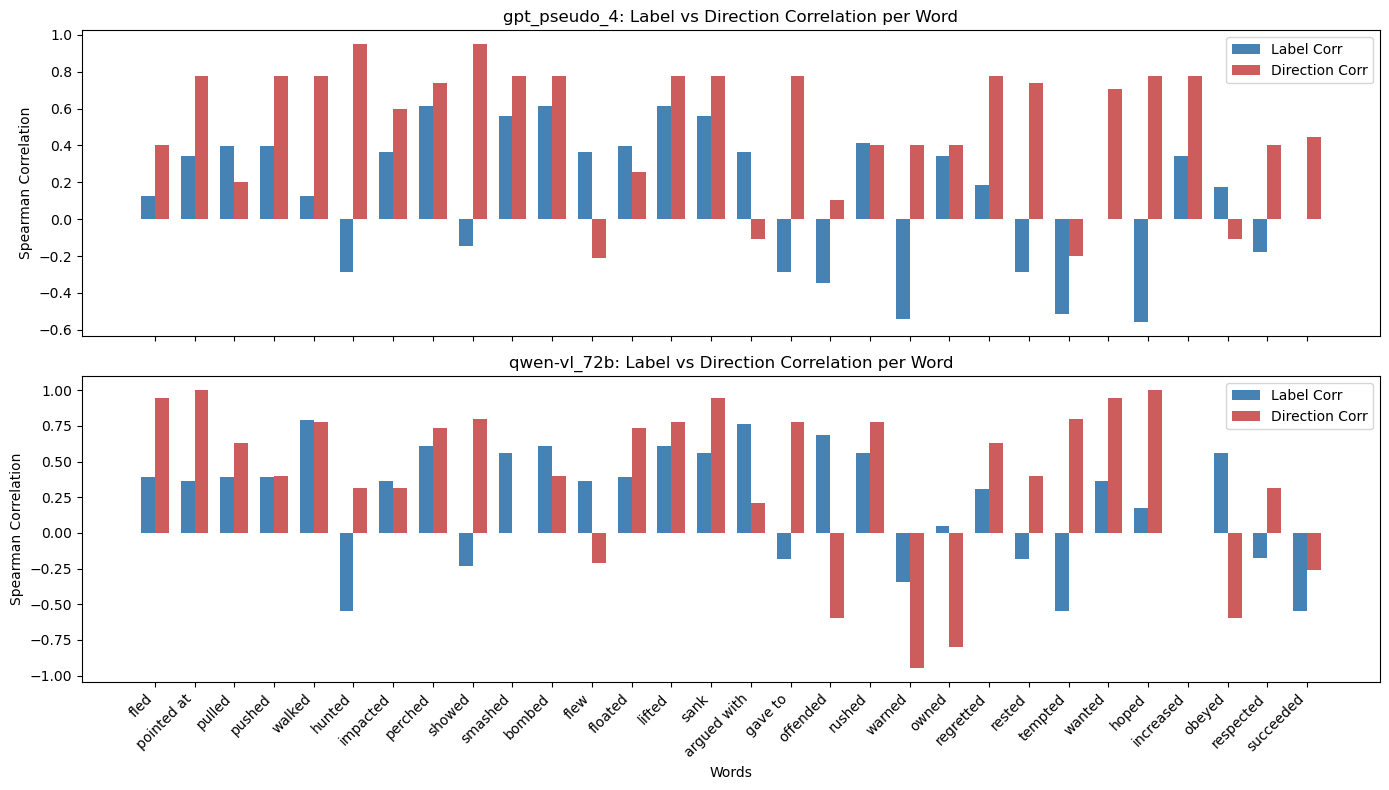

In [45]:
words = list(hmn_dict.keys())  # assuming every dict has the same set of words

llm_direction_corr = {}
vlm_direction_corr = {}
directions = ["up", "down", "left", "right"]

for word in words:
    # For LLM:
    llm_vals = [llm_dict[word][d] for d in directions]
    hmn_vals = [hmn_dict[word][d] for d in directions]
    corr_llm, _ = spearmanr(llm_vals, hmn_vals)
    # if one of the inputs is constant, spearmanr returns nan; set to 0.
    if corr_llm != corr_llm:
        corr_llm = 0.0
    llm_direction_corr[word] = corr_llm

    # For VLM:
    vlm_vals = [vlm_dict[word][d] for d in directions]
    corr_vlm, _ = spearmanr(vlm_vals, hmn_vals)
    if corr_vlm != corr_vlm:
        corr_vlm = 0.0
    vlm_direction_corr[word] = corr_vlm

# Extract the per-word label correlations from the earlier computations.
# For gpt_pseudo_4:
gpt_results = llm_results["gpt"]["pseudo_4"]
gpt_label_corr = [gpt_results[word]["spearman"] for word in words]

# For qwen-vl_72b:
qwen_results = vlm_results["qwen-vl"]["-72b"]
qwen_label_corr = [qwen_results[word]["spearman"] for word in words]

# Convert directional correlations into lists (ordered like words).
llm_dir_corr_list = [llm_direction_corr[word] for word in words]
vlm_dir_corr_list = [vlm_direction_corr[word] for word in words]

# Create figure with two vertically stacked grouped bar plots that share the x-axis.
fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
indices = np.arange(len(words))
bar_width = 0.35  # two bars per group

# Upper plot: LLM (gpt_pseudo_4) comparisons.
ax_top.bar(indices - bar_width/2, gpt_label_corr, width=bar_width, color="steelblue", label="Label Corr")
ax_top.bar(indices + bar_width/2, llm_dir_corr_list, width=bar_width, color="indianred", label="Direction Corr")
ax_top.set_ylabel("Spearman Correlation")
ax_top.set_title("gpt_pseudo_4: Label vs Direction Correlation per Word")
ax_top.legend()
ax_top.tick_params(axis="x", labelbottom=False)

# Lower plot: VLM (qwen-vl_72b) comparisons.
ax_bot.bar(indices - bar_width/2, qwen_label_corr, width=bar_width, color="steelblue", label="Label Corr")
ax_bot.bar(indices + bar_width/2, vlm_dir_corr_list, width=bar_width, color="indianred", label="Direction Corr")
ax_bot.set_ylabel("Spearman Correlation")
ax_bot.set_title("qwen-vl_72b: Label vs Direction Correlation per Word")
ax_bot.legend()
ax_bot.set_xticks(indices)
ax_bot.set_xticklabels(words, rotation=45, ha="right")
ax_bot.set_xlabel("Words")

plt.tight_layout()
plt.show()

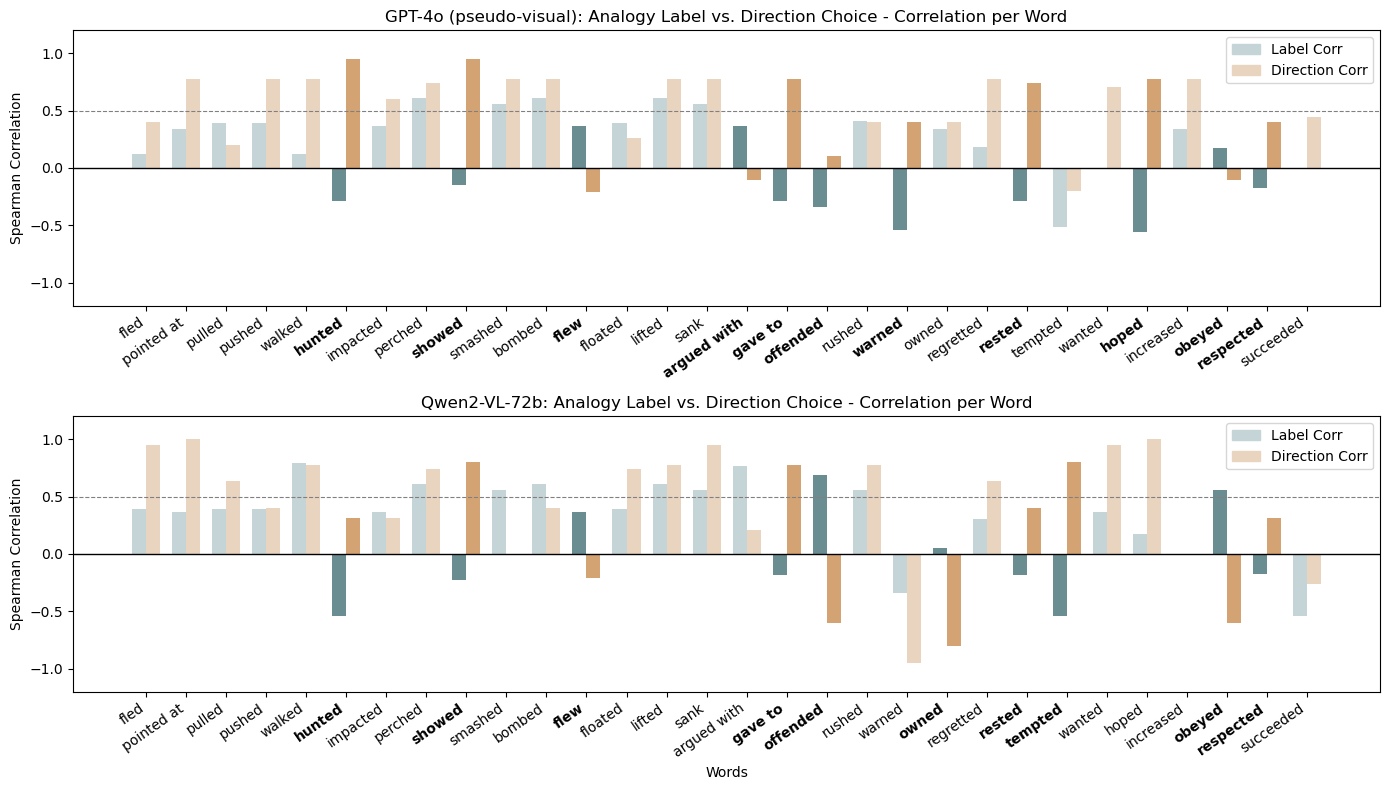

In [46]:
# Create figure with two vertically stacked grouped bar plots that share the x-axis.
import matplotlib.patches as mpatches

fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=False, figsize=(14, 8))
bar_width = 0.35
indices = np.arange(len(words))

# Define colors for light and bold versions (high contrast uses dark colors)
light_label_color = "#C5D4D6"      # Pale Turquoise
bold_label_color  = "#6A8D92"       # Dark Teal
light_direction_color = "#E9D4C0"   # Moccasin (Light Orange)
bold_direction_color  = "#D4A373"    # Dark Orange


# --- Top plot: gpt_pseudo_4 (LLM) ---
for i, word in enumerate(words):
    lab_corr = gpt_label_corr[i]
    dir_corr = llm_dir_corr_list[i]
    # Choose colors: bold if correlations differ in sign.
    if lab_corr * dir_corr < 0:
        col_lab = bold_label_color
        col_dir = bold_direction_color
    else:
        col_lab = light_label_color
        col_dir = light_direction_color

    ax_top.bar(indices[i] - bar_width/2, lab_corr, width=bar_width, color=col_lab)
    ax_top.bar(indices[i] + bar_width/2, dir_corr, width=bar_width, color=col_dir)

# Subtle horizontal dashed lines at correlation = 0.5 and a solid line at 0.
if any(val > 0.5 for val in gpt_label_corr + llm_dir_corr_list):
    ax_top.axhline(0.5, color="grey", linestyle="--", linewidth=0.8)
ax_top.axhline(0, color="black", linestyle="-", linewidth=1)

ax_top.set_ylabel("Spearman Correlation")
ax_top.set_title("GPT-4o (pseudo-visual): Analogy Label vs. Direction Choice - Correlation per Word")
ax_top.set_ylim(-1.2, 1.2)
ax_top.set_xticks(indices)
ax_top.set_xticklabels(words, rotation=35, ha="right")  # Show x-axis labels for top plot

# --- Bottom plot: qwen-vl_72b (VLM) ---
for i, word in enumerate(words):
    lab_corr = qwen_label_corr[i]
    dir_corr = vlm_dir_corr_list[i]
    if lab_corr * dir_corr < 0:
        col_lab = bold_label_color
        col_dir = bold_direction_color
    else:
        col_lab = light_label_color
        col_dir = light_direction_color

    ax_bot.bar(indices[i] - bar_width/2, lab_corr, width=bar_width, color=col_lab)
    ax_bot.bar(indices[i] + bar_width/2, dir_corr, width=bar_width, color=col_dir)

if any(val > 0.5 for val in qwen_label_corr + vlm_dir_corr_list):
    ax_bot.axhline(0.5, color="grey", linestyle="--", linewidth=0.8)
ax_bot.axhline(0, color="black", linestyle="-", linewidth=1)

ax_bot.set_ylabel("Spearman Correlation")
ax_bot.set_title("Qwen2-VL-72b: Analogy Label vs. Direction Choice - Correlation per Word")
ax_bot.set_xlabel("Words")
ax_bot.set_ylim(-1.2, 1.2)
ax_bot.set_xticks(indices)
ax_bot.set_xticklabels(words, rotation=35, ha="right")

# Bold the x-axis tick labels for words with high contrast in both subplots.
for ax, lab_corr_list, dir_corr_list in [(ax_top, gpt_label_corr, llm_dir_corr_list),
                                           (ax_bot, qwen_label_corr, vlm_dir_corr_list)]:
    for i, label in enumerate(ax.get_xticklabels()):
        if lab_corr_list[i] * dir_corr_list[i] < 0:
            label.set_fontweight("bold")

# Create custom legend handles representing the metrics.
label_patch = mpatches.Patch(color=light_label_color, label="Label Corr")
direction_patch = mpatches.Patch(color=light_direction_color, label="Direction Corr")
ax_top.legend(handles=[label_patch, direction_patch])
ax_bot.legend(handles=[label_patch, direction_patch])

plt.tight_layout()
plt.savefig('../../data/human_results/figures/correlation_contrast.png', dpi=300,bbox_inches='tight')
plt.show()

In [47]:
# Calculate the absolute distances between label and direction correlations for each word.
distance_llm = {word: abs(gpt_label_corr[i] - llm_dir_corr_list[i]) for i, word in enumerate(words)}
distance_vlm = {word: abs(qwen_label_corr[i] - vlm_dir_corr_list[i]) for i, word in enumerate(words)}

# Lower the threshold to a less strict value, e.g., the 50th percentile.
threshold_llm = np.percentile(list(distance_llm.values()), 50)
threshold_vlm = np.percentile(list(distance_vlm.values()), 50)

# Option 1: Use the intersection (words must exceed threshold for both models)
selected_words = [word for word in words 
                  if distance_llm[word] >= threshold_llm and distance_vlm[word] >= threshold_vlm]

# Option 2: Use the union (words exceed threshold in at least one model)
# selected_words = list({word for word in words 
#                        if distance_llm[word] >= threshold_llm or distance_vlm[word] >= threshold_vlm})

print("Words with highest correlation distance for both models:")
for word in selected_words:
    print(word, "LLM distance:", round(distance_llm[word],4))
    print("VLM distance:", round(distance_vlm[word],4))
    print()

Words with highest correlation distance for both models:
pointed at LLM distance: 0.4305
VLM distance: 0.6373

hunted LLM distance: 1.2355
VLM distance: 0.8603

showed LLM distance: 1.0968
VLM distance: 1.0294

flew LLM distance: 0.5736
VLM distance: 0.5736

gave to LLM distance: 1.0614
VLM distance: 0.956

offended LLM distance: 0.4495
VLM distance: 1.2882

warned LLM distance: 0.9441
VLM distance: 0.6046

rested LLM distance: 1.0246
VLM distance: 0.5814

wanted LLM distance: 0.7071
VLM distance: 0.5859

hoped LLM distance: 1.3336
VLM distance: 0.8232



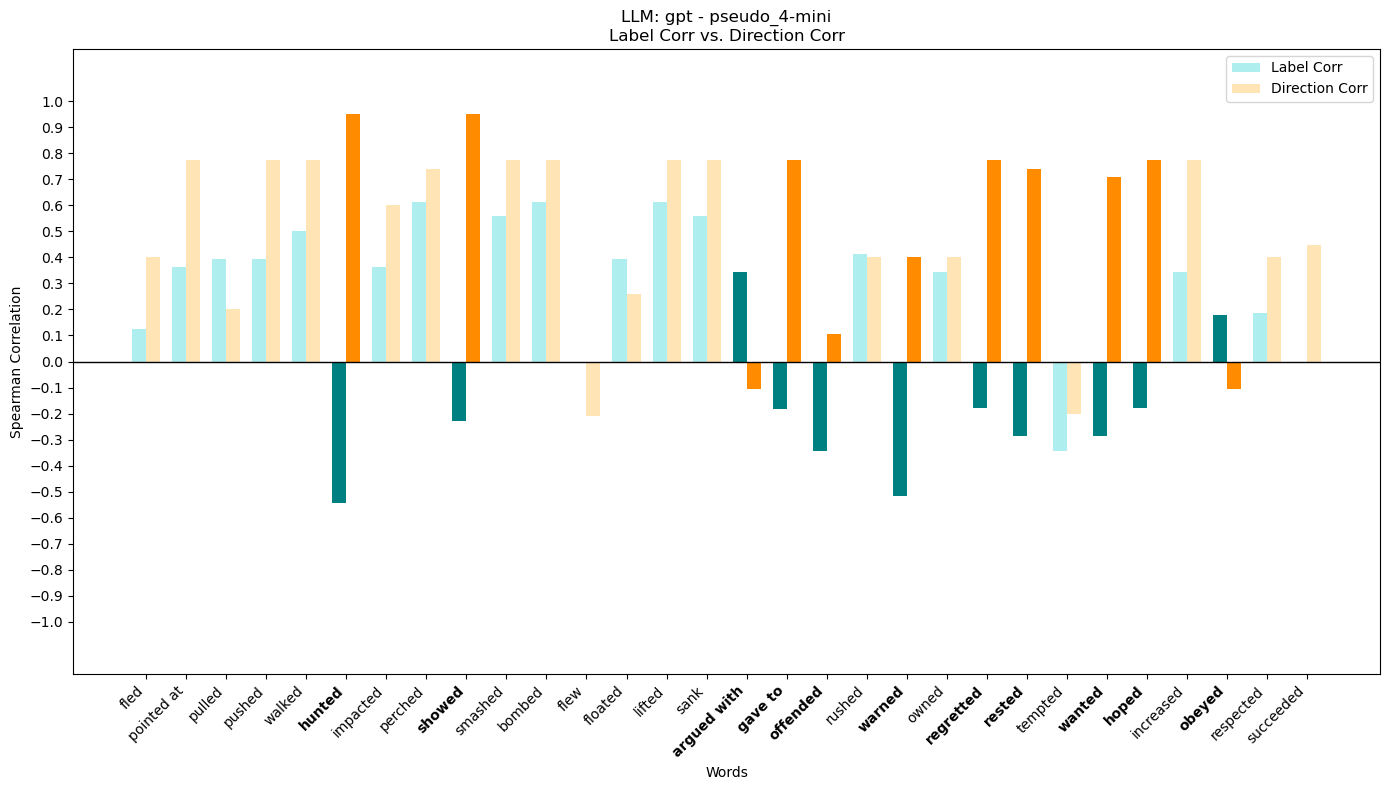

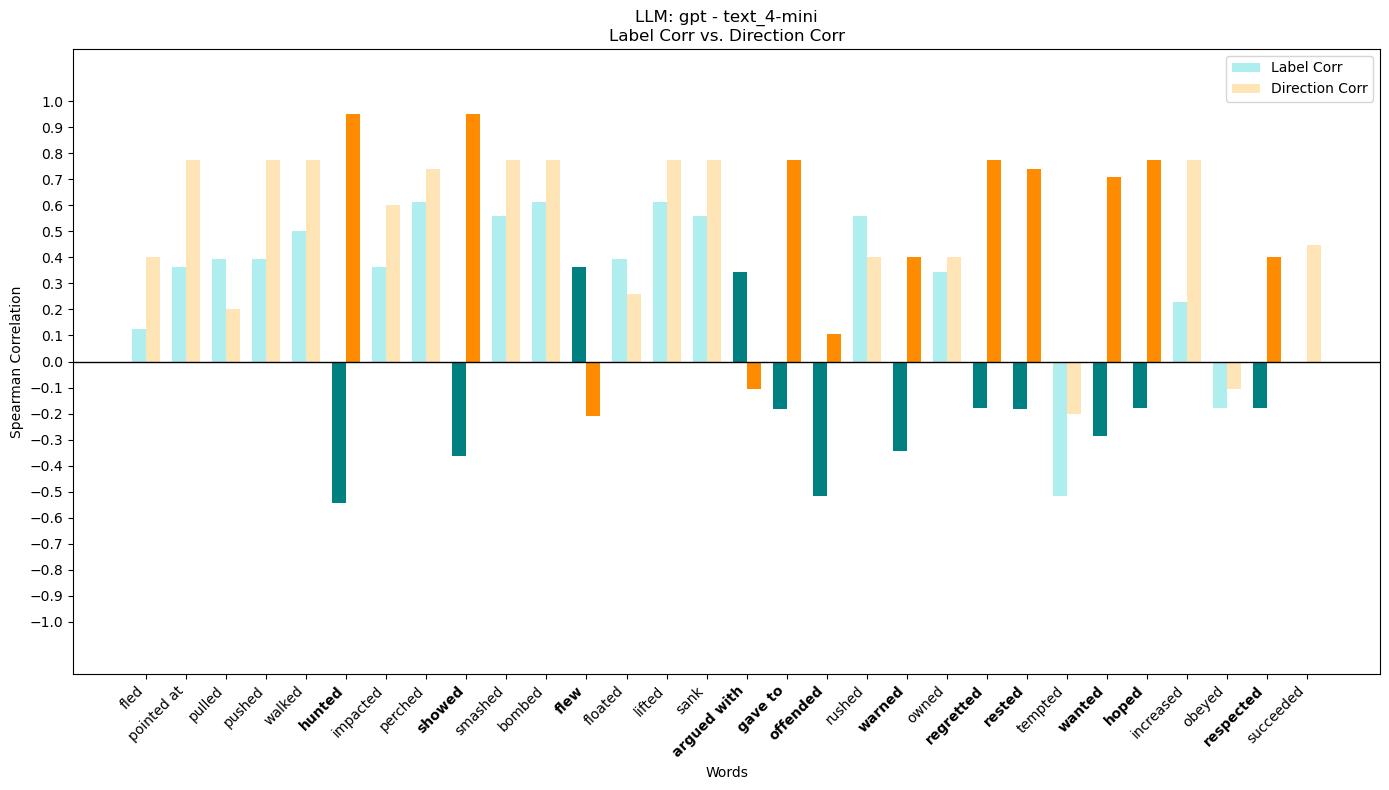

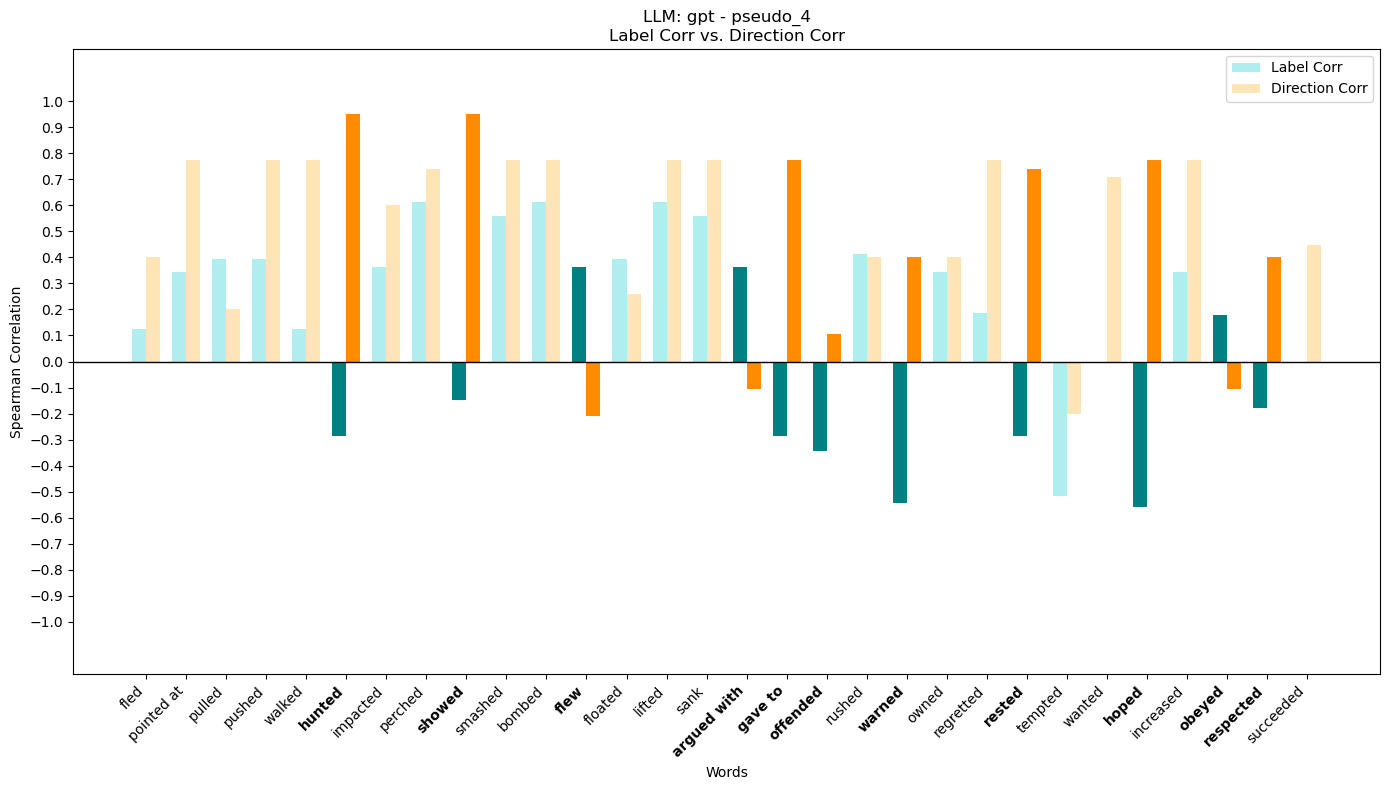

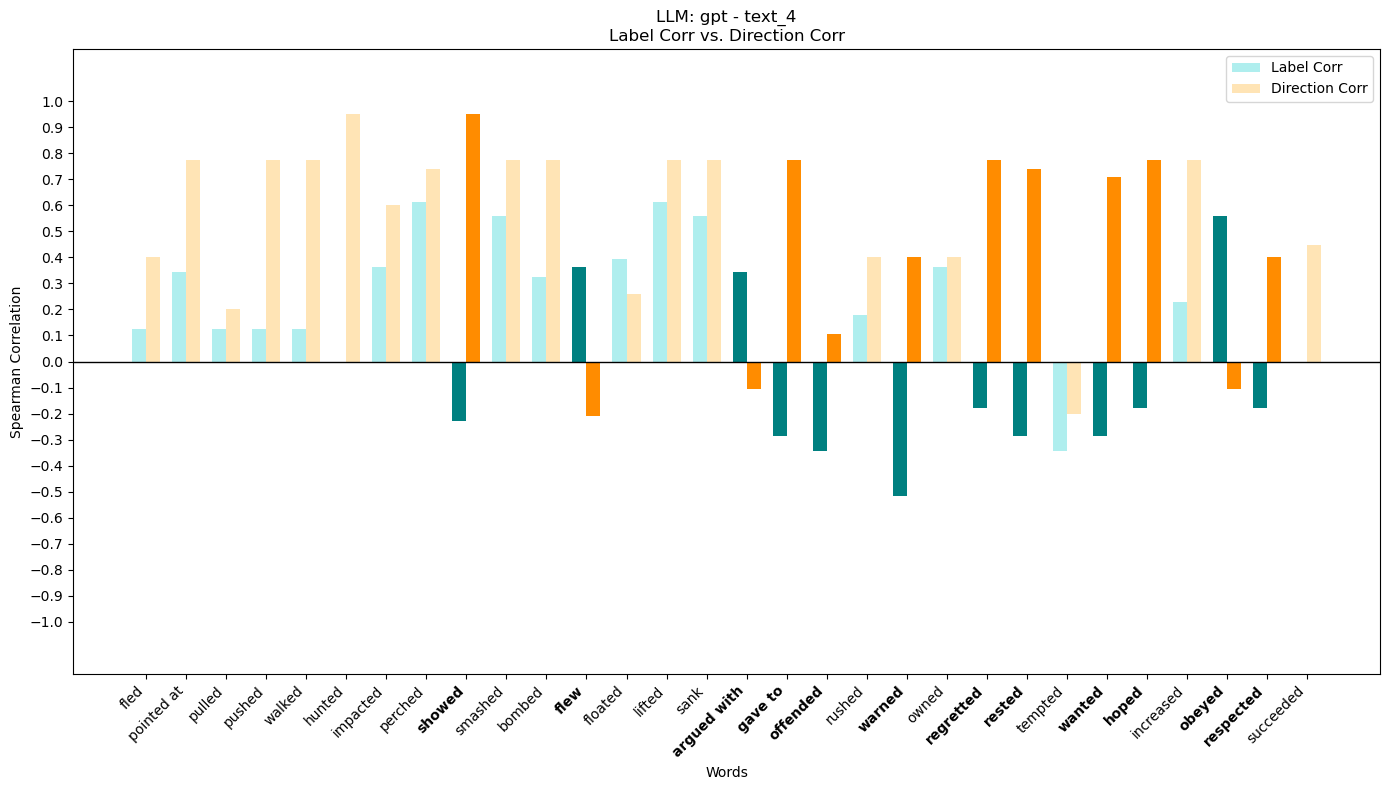

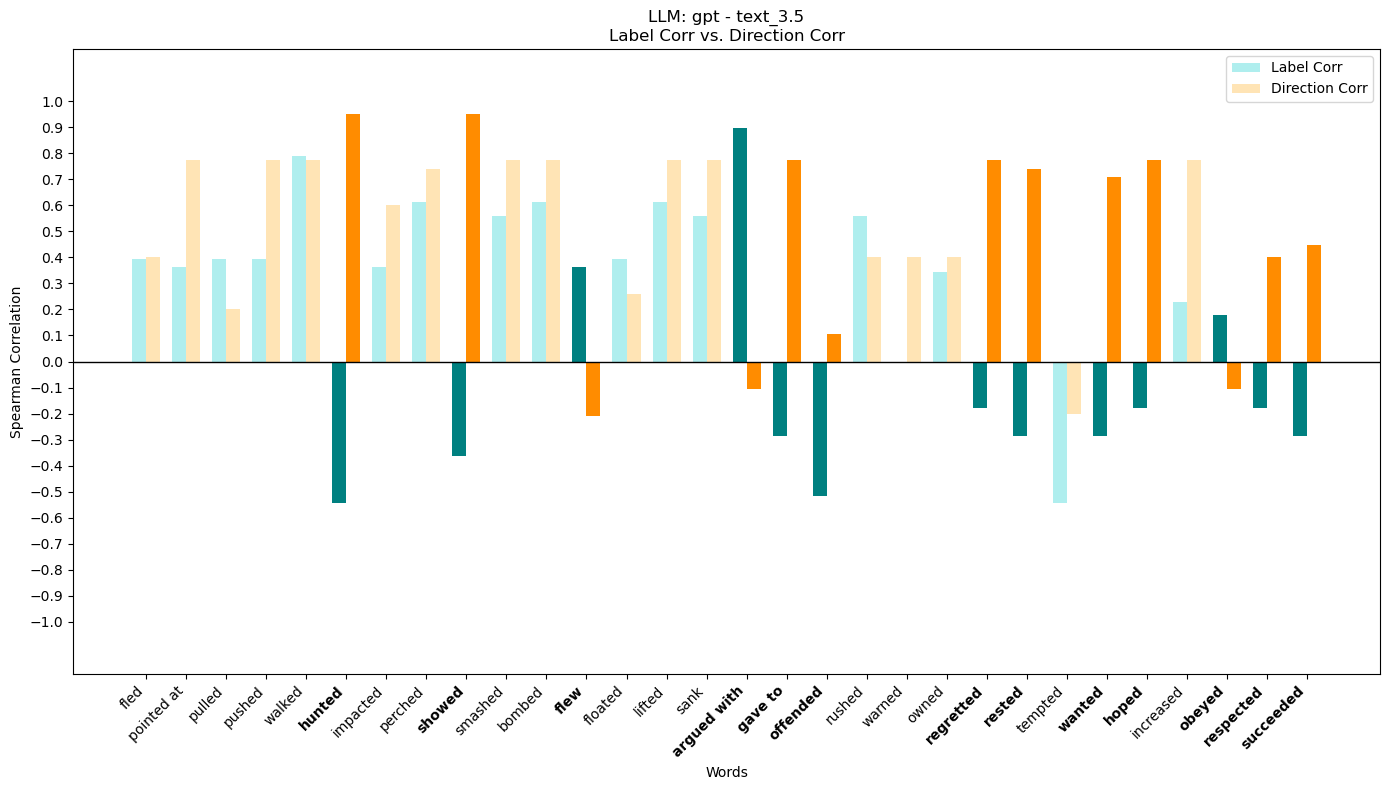

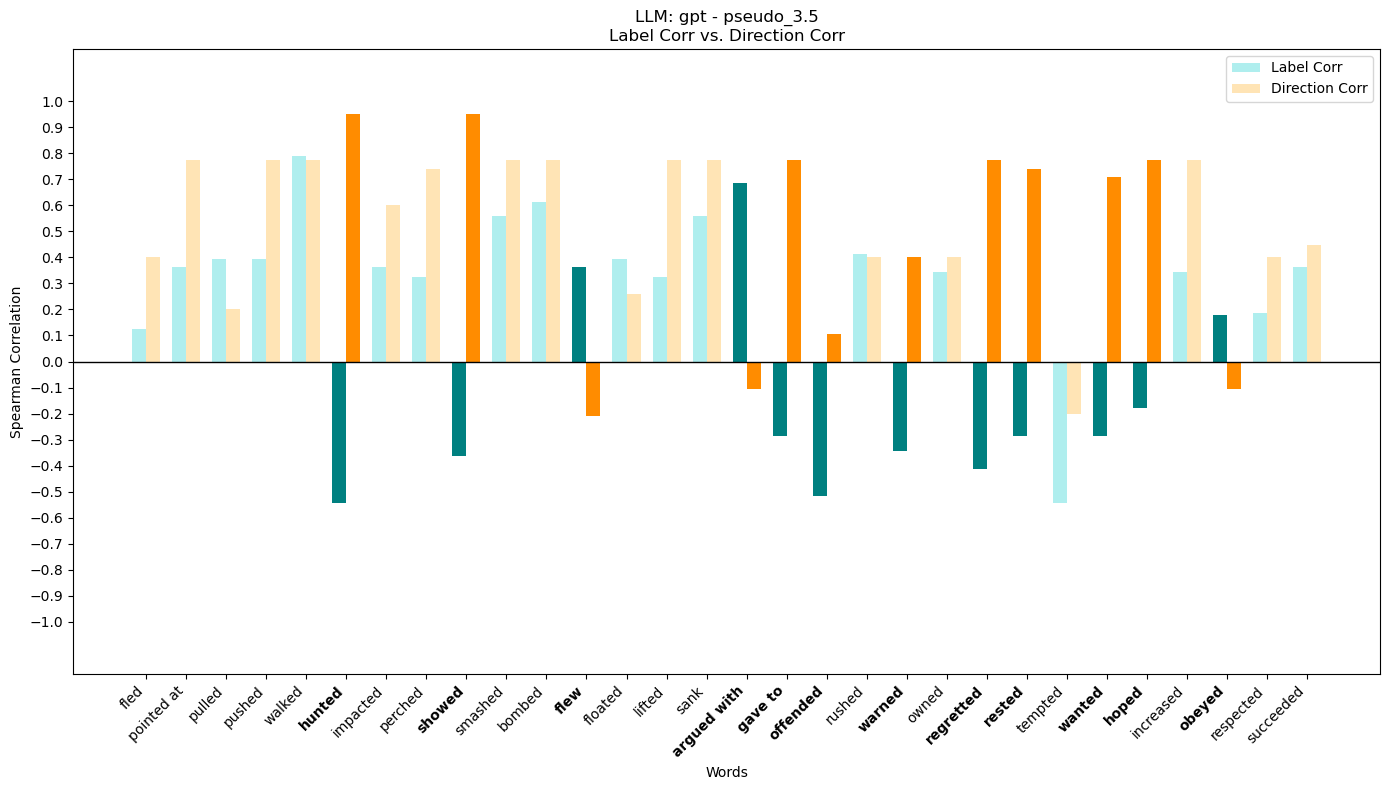

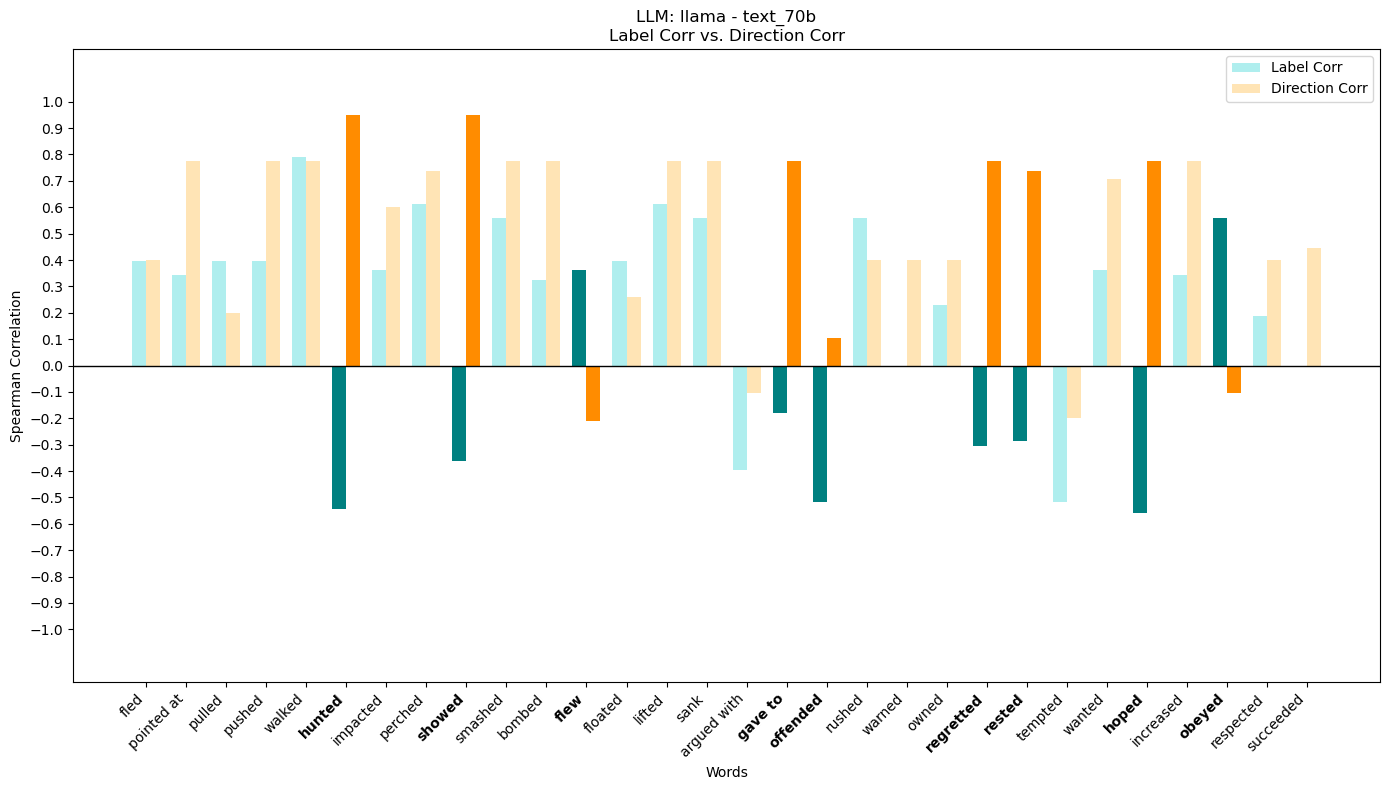

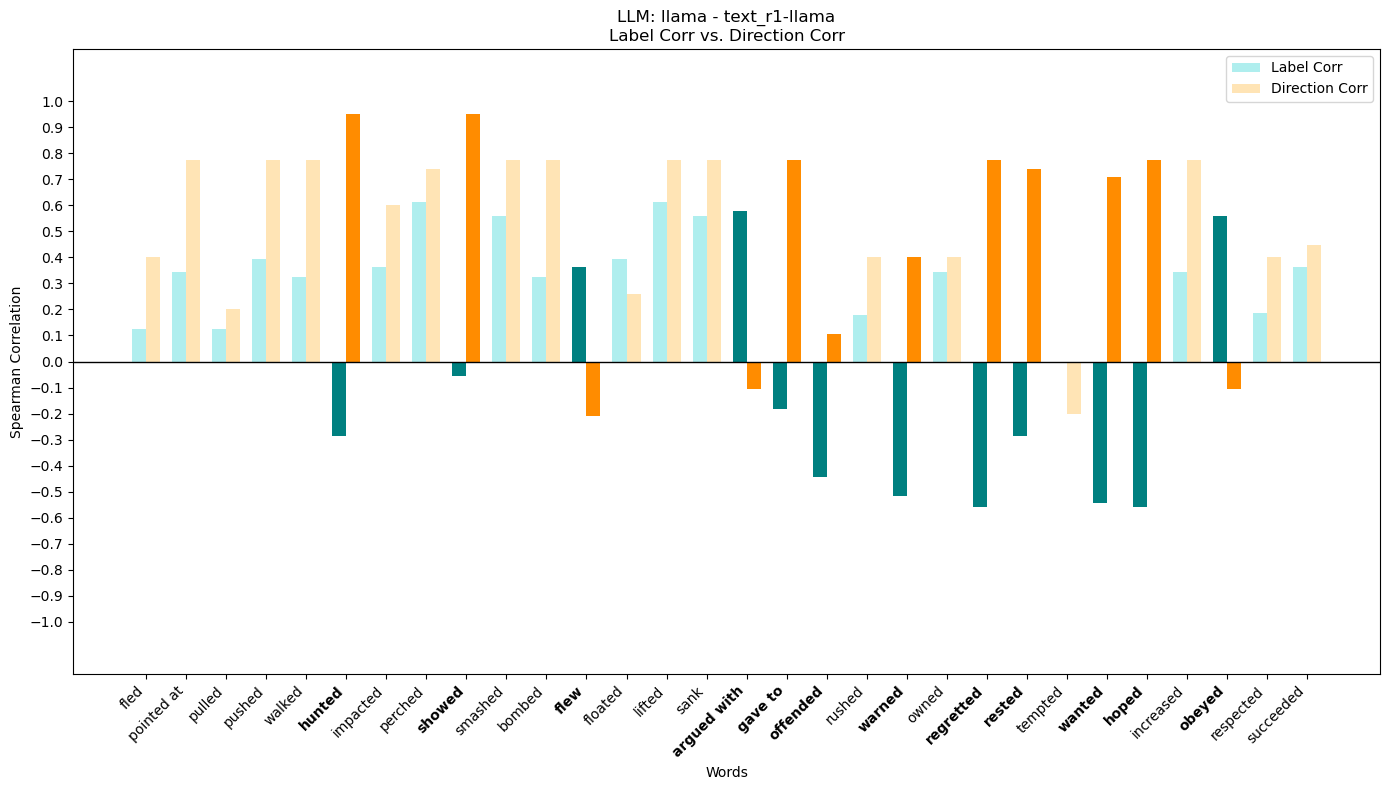

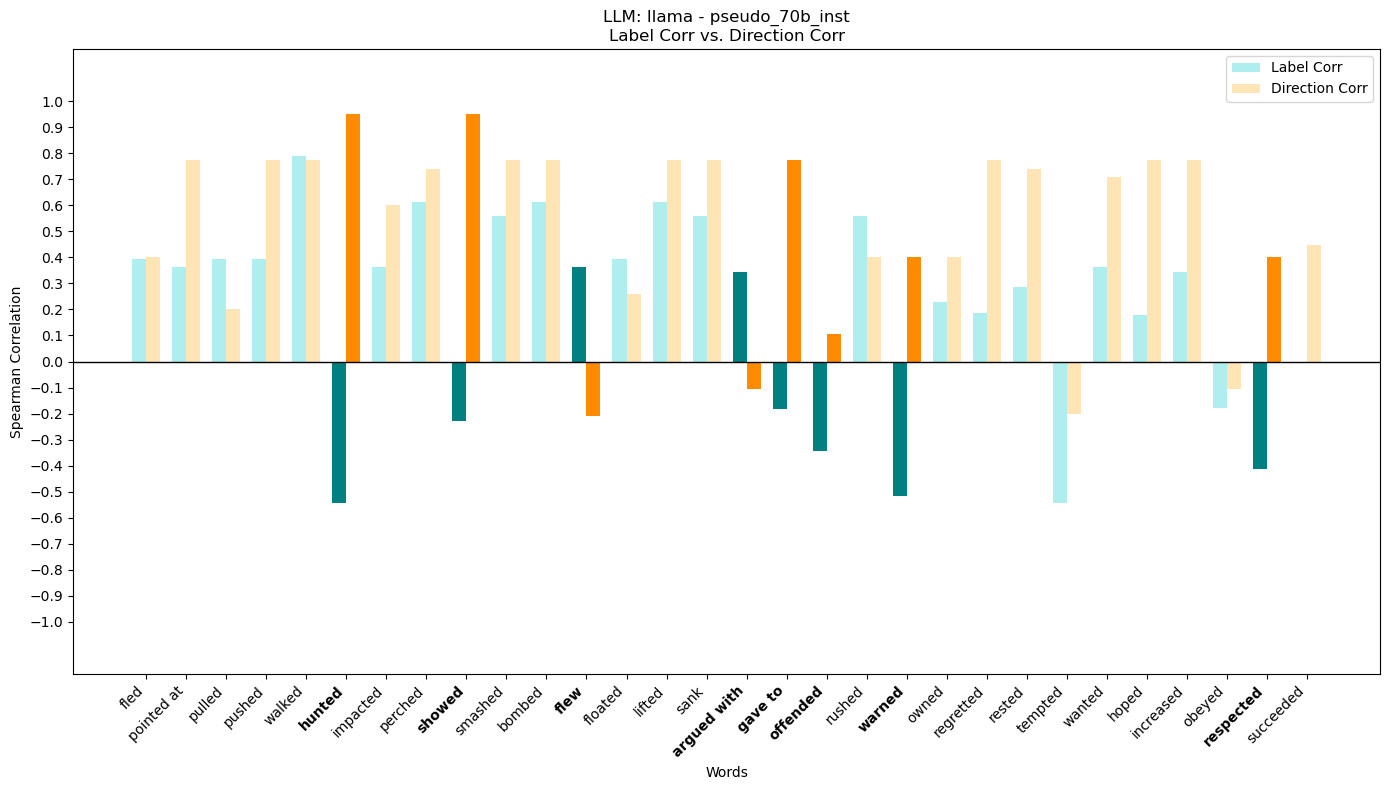

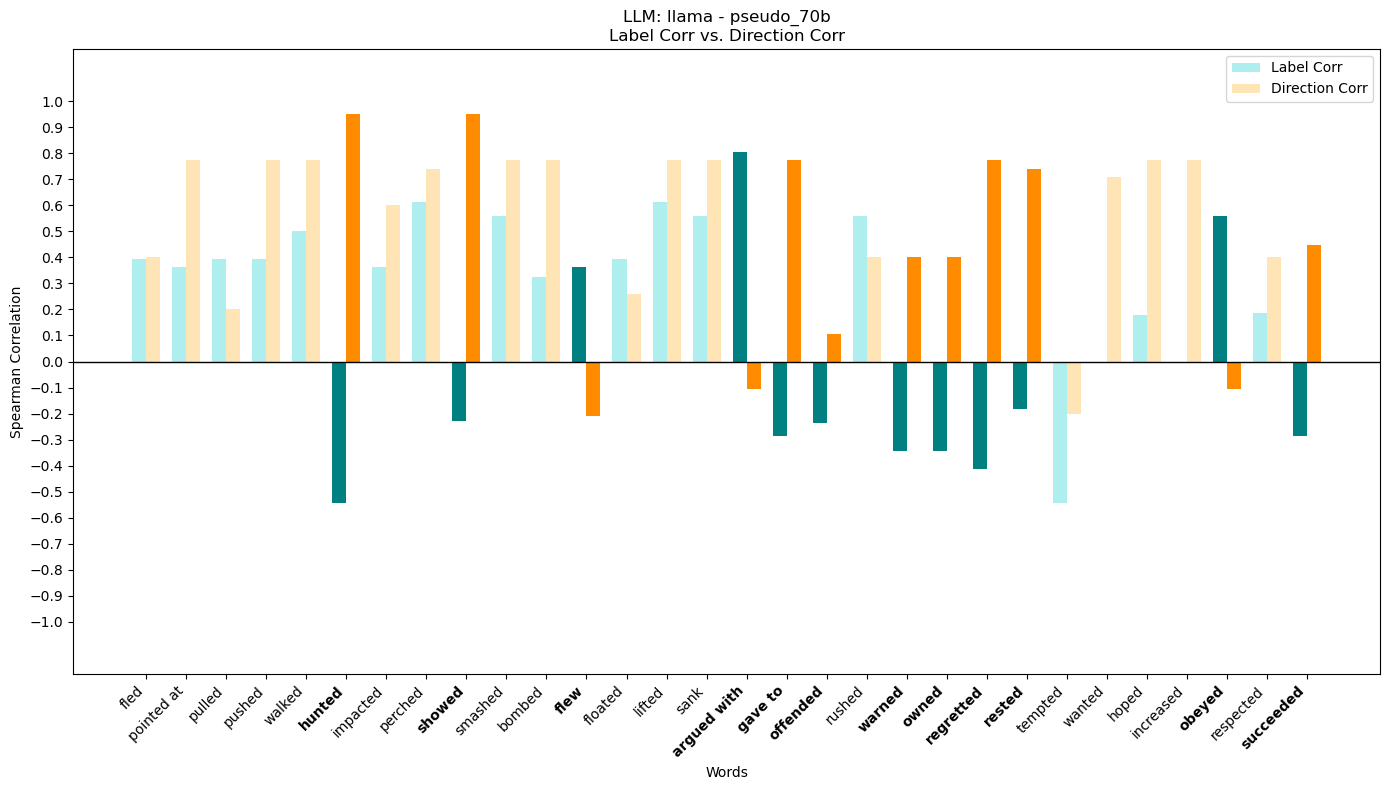

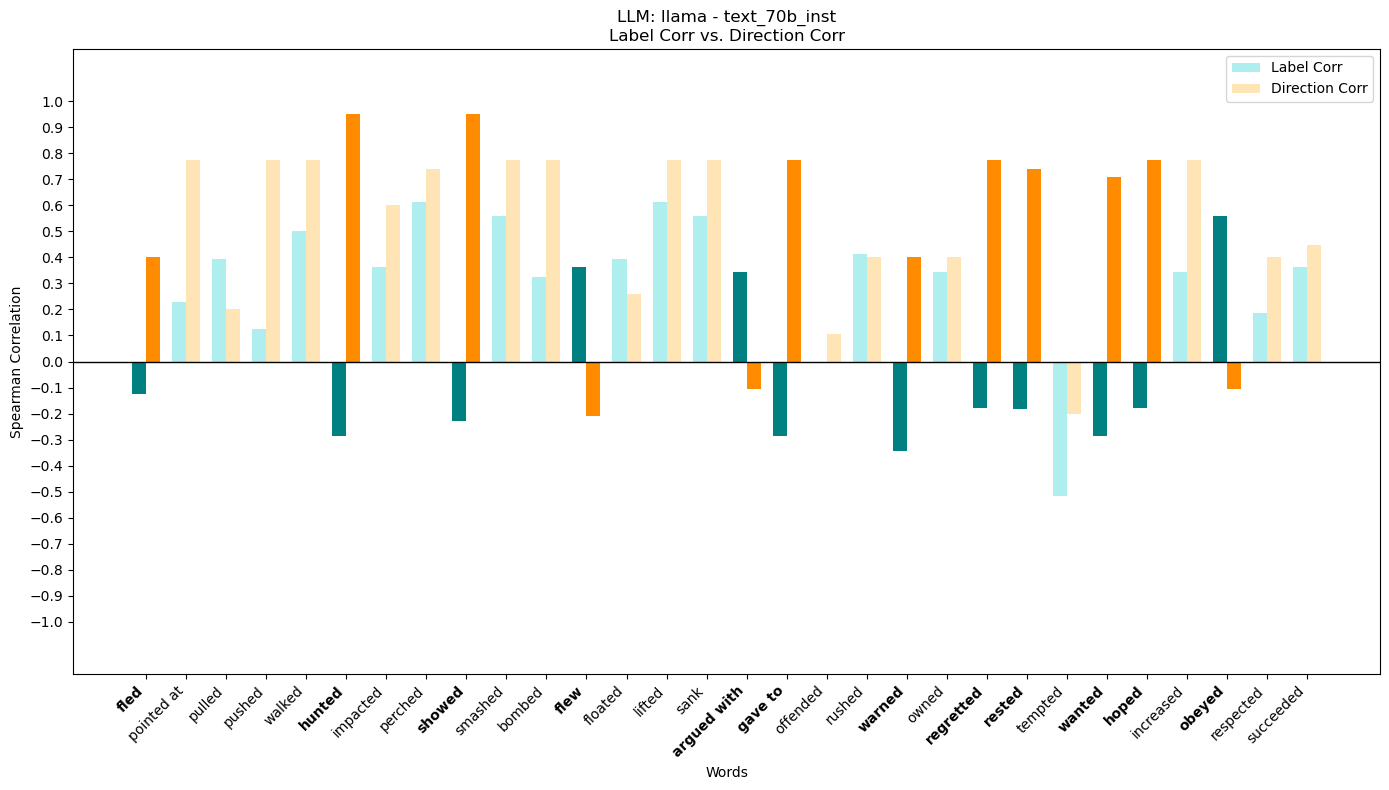

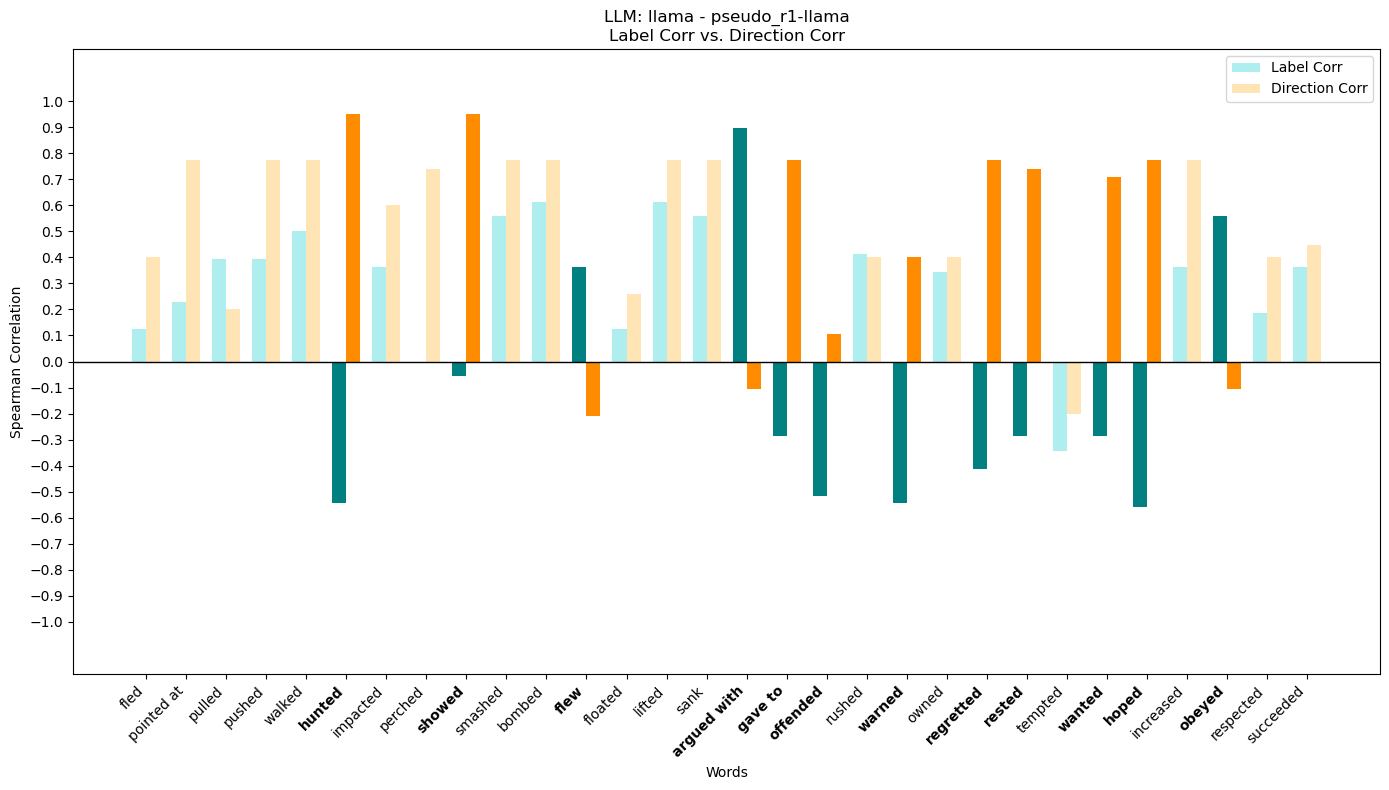

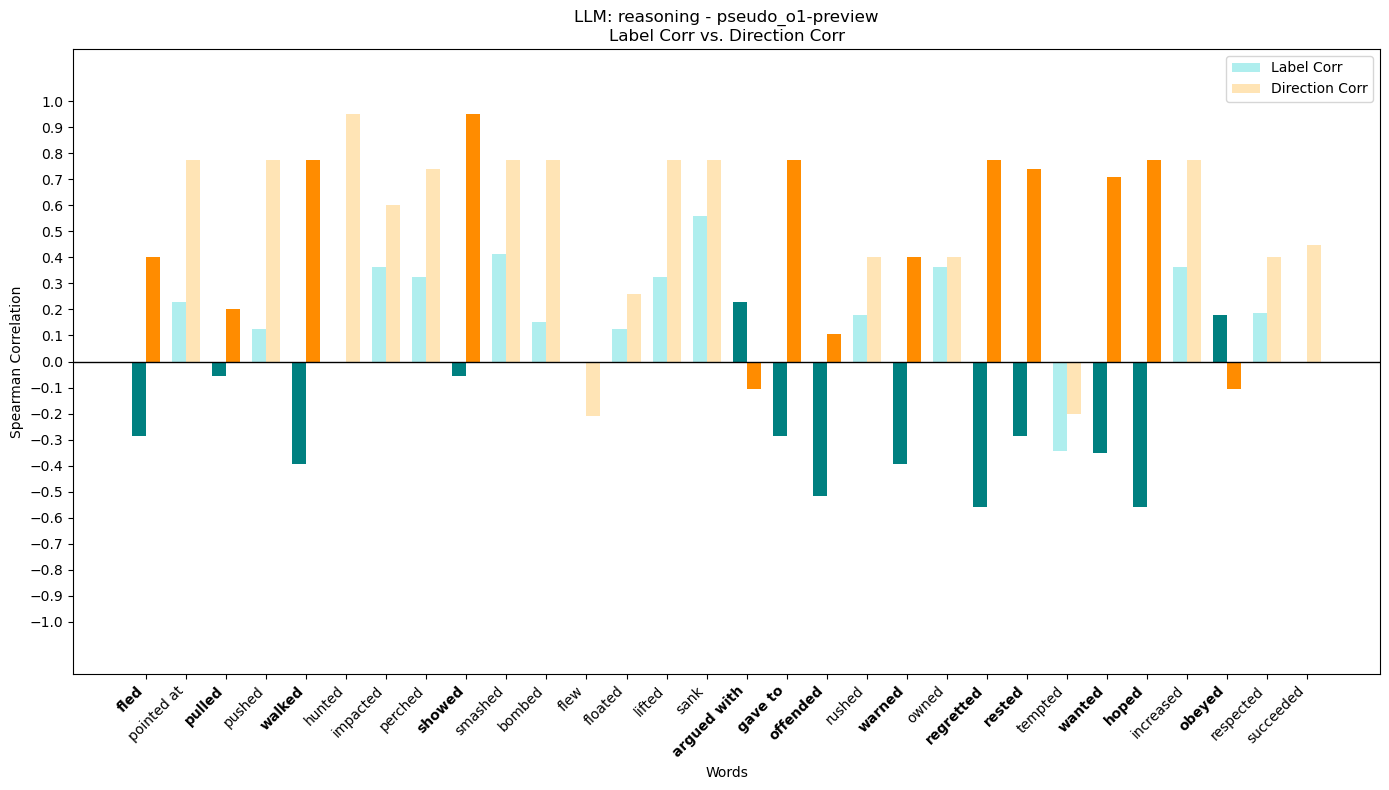

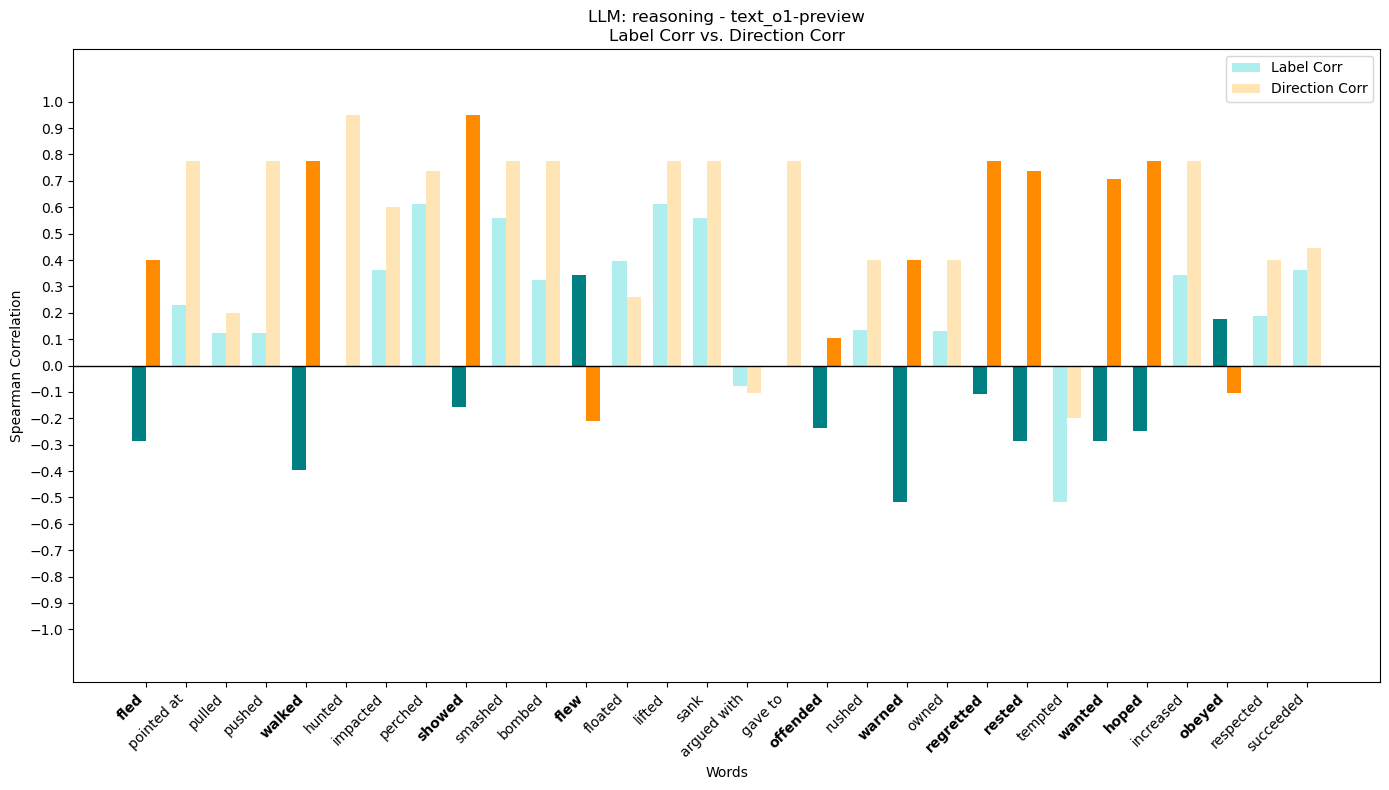

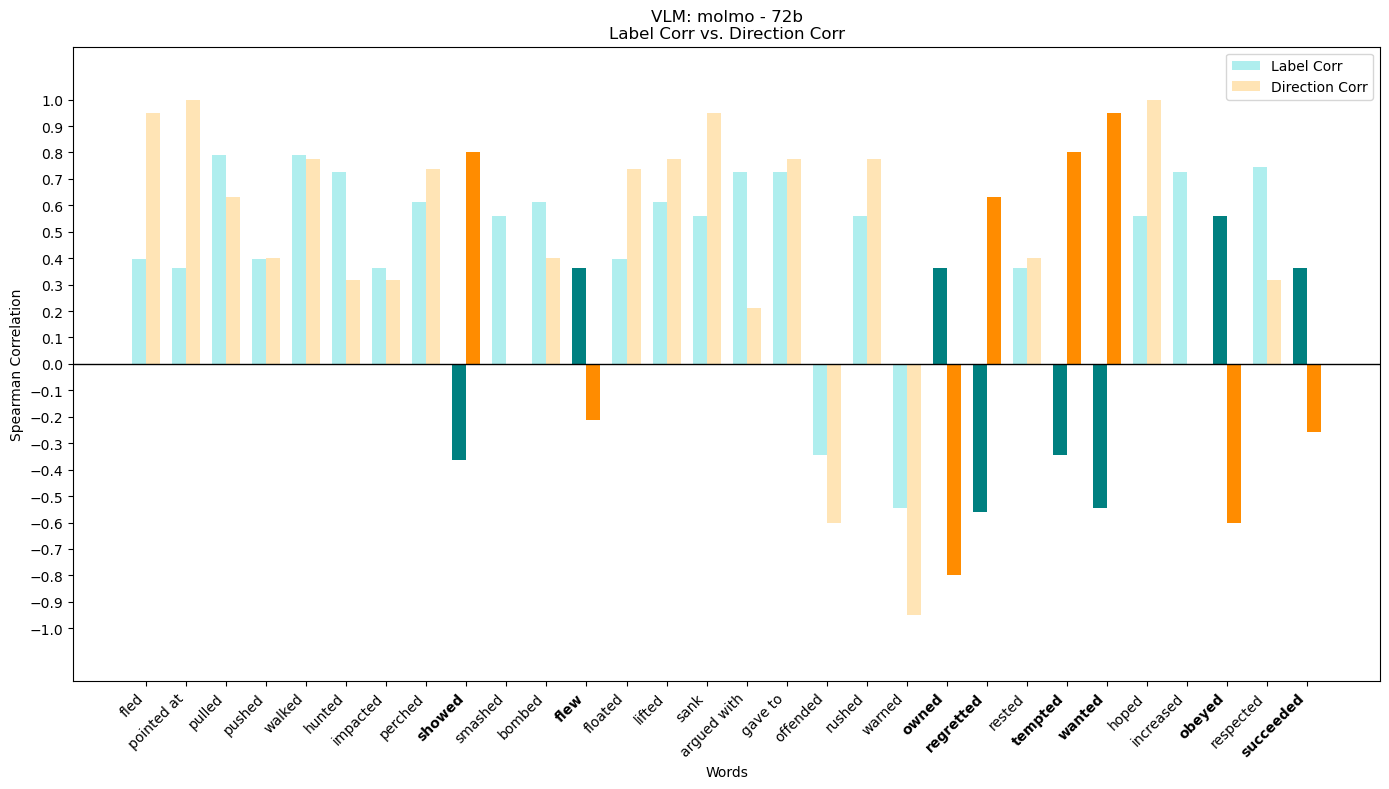

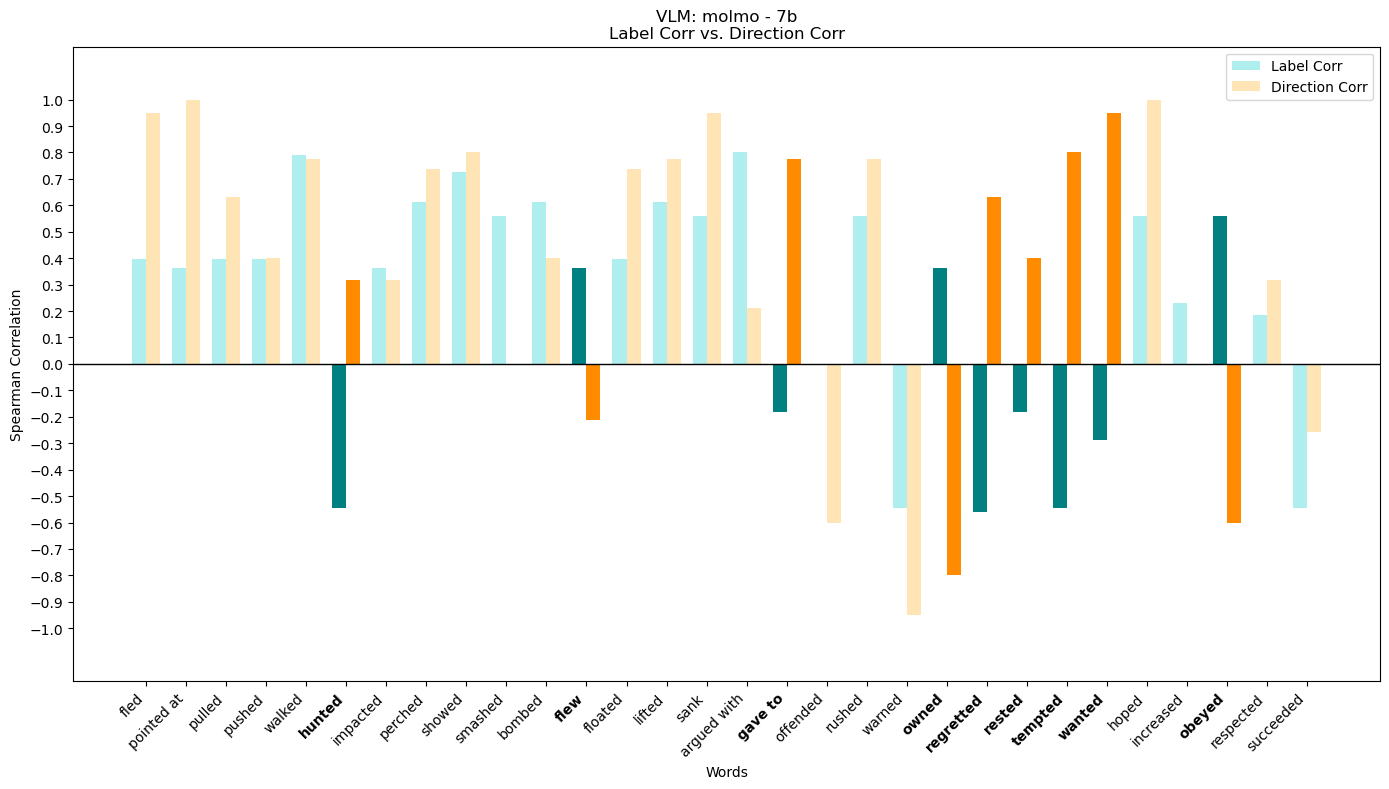

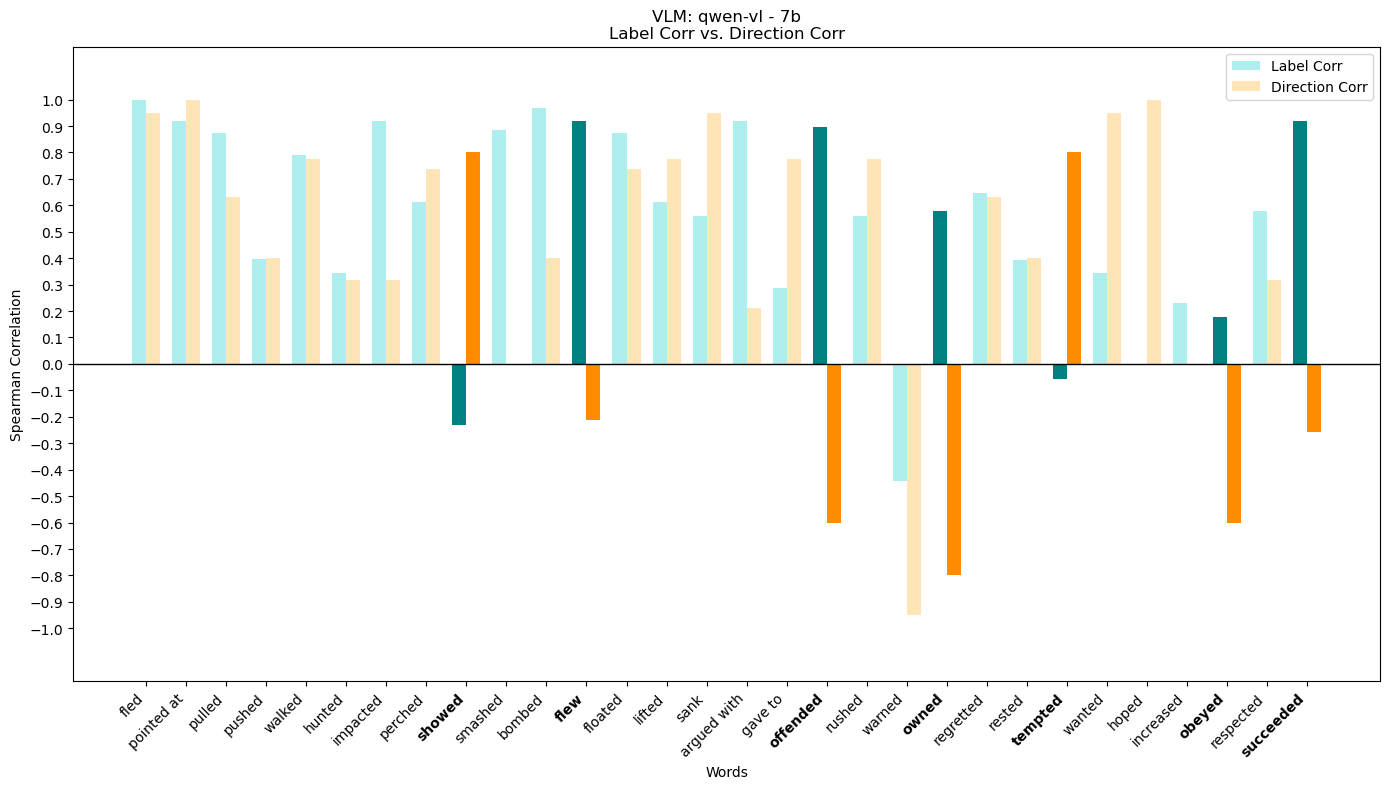

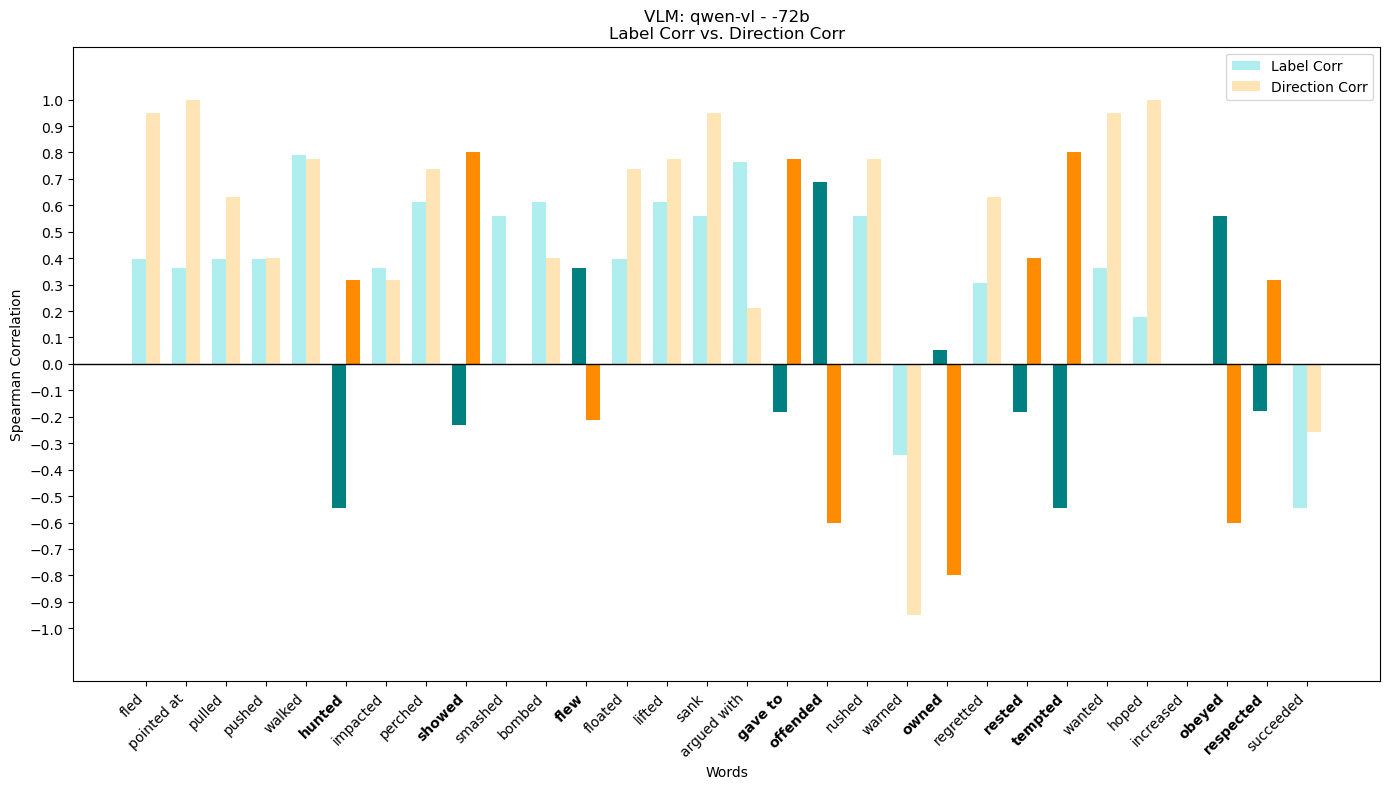

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from matplotlib.patches import Patch

# ----- Assumptions:
# • llm_results:  {model_name: {condition: {word: {"spearman": value, ...}, ...}, ...}
# • vlm_results: similar structure for VLMs.
# • llm_dict, vlm_dict, hmn_dict: {word: {direction (e.g. "up"): value, "down": value, ...}}
# • The set of words is assumed to be identical across dictionaries.
# -----------------------------

# Define directions for computing directional correlation.
directions = ["up", "down", "left", "right"]

# Define colors for light and bold versions (high contrast uses dark colors).
light_label_color     = "#AFEEEE"  # Pale Turquoise
bold_label_color      = "#008080"   # Dark Teal
light_direction_color = "#FFE4B5"   # Moccasin (Light Orange)
bold_direction_color  = "#FF8C00"   # Dark Orange

# Bar width (for side-by-side bars).
bar_width = 0.35

def plot_model_results(model_type, model_name, cond, results_dict, directional_dict):
    """
    Create an individual plot for one model/condition combination.
    
    model_type: "LLM" or "VLM"
    model_name: the model identifier (e.g. "gpt", "qwen-vl")
    cond: the condition string (e.g. "pseudo_4", "72b", etc.)
    results_dict: dictionary holding label correlations (llm_results or vlm_results)
    directional_dict: dictionary holding directional frequencies for that modality 
                      (llm_dict for LLMs, vlm_dict for VLMs)
    """
    # Extract the per-word label correlation (Spearman) for this model/condition.
    word_data = results_dict[model_name][cond]
    words = list(word_data.keys())
    label_corr = [word_data[word]["spearman"] for word in words]
    
    # Compute the directional correlation for each word using the provided directional dictionary (and hmn_dict).
    dir_corr = []
    for word in words:
        # Model directional frequencies.
        model_dir_values = [directional_dict[word][d] for d in directions]
        # Human directional frequencies.
        human_dir_values = [hmn_dict[word][d] for d in directions]
        corr, _ = spearmanr(model_dir_values, human_dir_values)
        if np.isnan(corr):
            corr = 0.0
        dir_corr.append(corr)
    
    indices = np.arange(len(words))
    
    # Create a new figure.
    plt.figure(figsize=(14, 8))
    for i, word in enumerate(words):
        lab_val = label_corr[i]
        d_val = dir_corr[i]
        # Use bold colors if the two correlations are opposed (i.e. product < 0), light colors otherwise.
        if lab_val * d_val < 0:  
            color_lab = bold_label_color
            color_dir = bold_direction_color
        else:
            color_lab = light_label_color
            color_dir = light_direction_color
            
        # Plot the two bars side by side.
        plt.bar(indices[i] - bar_width/2, lab_val, width=bar_width, color=color_lab)
        plt.bar(indices[i] + bar_width/2, d_val, width=bar_width, color=color_dir)
    
    # Draw horizontal reference lines:
    plt.axhline(0, color='black', linewidth=1)
    # Set the y-axis limits and ticks.
    plt.ylim(-1.2, 1.2)
    plt.yticks(np.arange(-1, 1.01, 0.1))
    
    # Set x-axis ticks and labels.
    plt.xticks(indices, words, rotation=45, ha="right")
    # Bold the tick label for words with high contrast.
    ax = plt.gca()
    for i, tick_label in enumerate(ax.get_xticklabels()):
        if label_corr[i] * dir_corr[i] < 0:
            tick_label.set_fontweight("bold")
            
    # Add labels and title.
    plt.xlabel("Words")
    plt.ylabel("Spearman Correlation")
    plt.title(f"{model_type}: {model_name} - {cond}\nLabel Corr vs. Direction Corr")
    
    # Create a custom legend.
    legend_handles = [
        Patch(facecolor=light_label_color, label="Label Corr"),
        Patch(facecolor=light_direction_color, label="Direction Corr")
    ]
    plt.legend(handles=legend_handles)
    
    plt.tight_layout()
    plt.show()

# ===========================
# Loop over all LLMs and generate individual plots.
for model_name in llm_results:
    for cond in llm_results[model_name]:
        plot_model_results("LLM", model_name, cond, llm_results, llm_dict)

# Loop over all VLMs and generate individual plots.
for model_name in vlm_results:
    for cond in vlm_results[model_name]:
        plot_model_results("VLM", model_name, cond, vlm_results, vlm_dict)

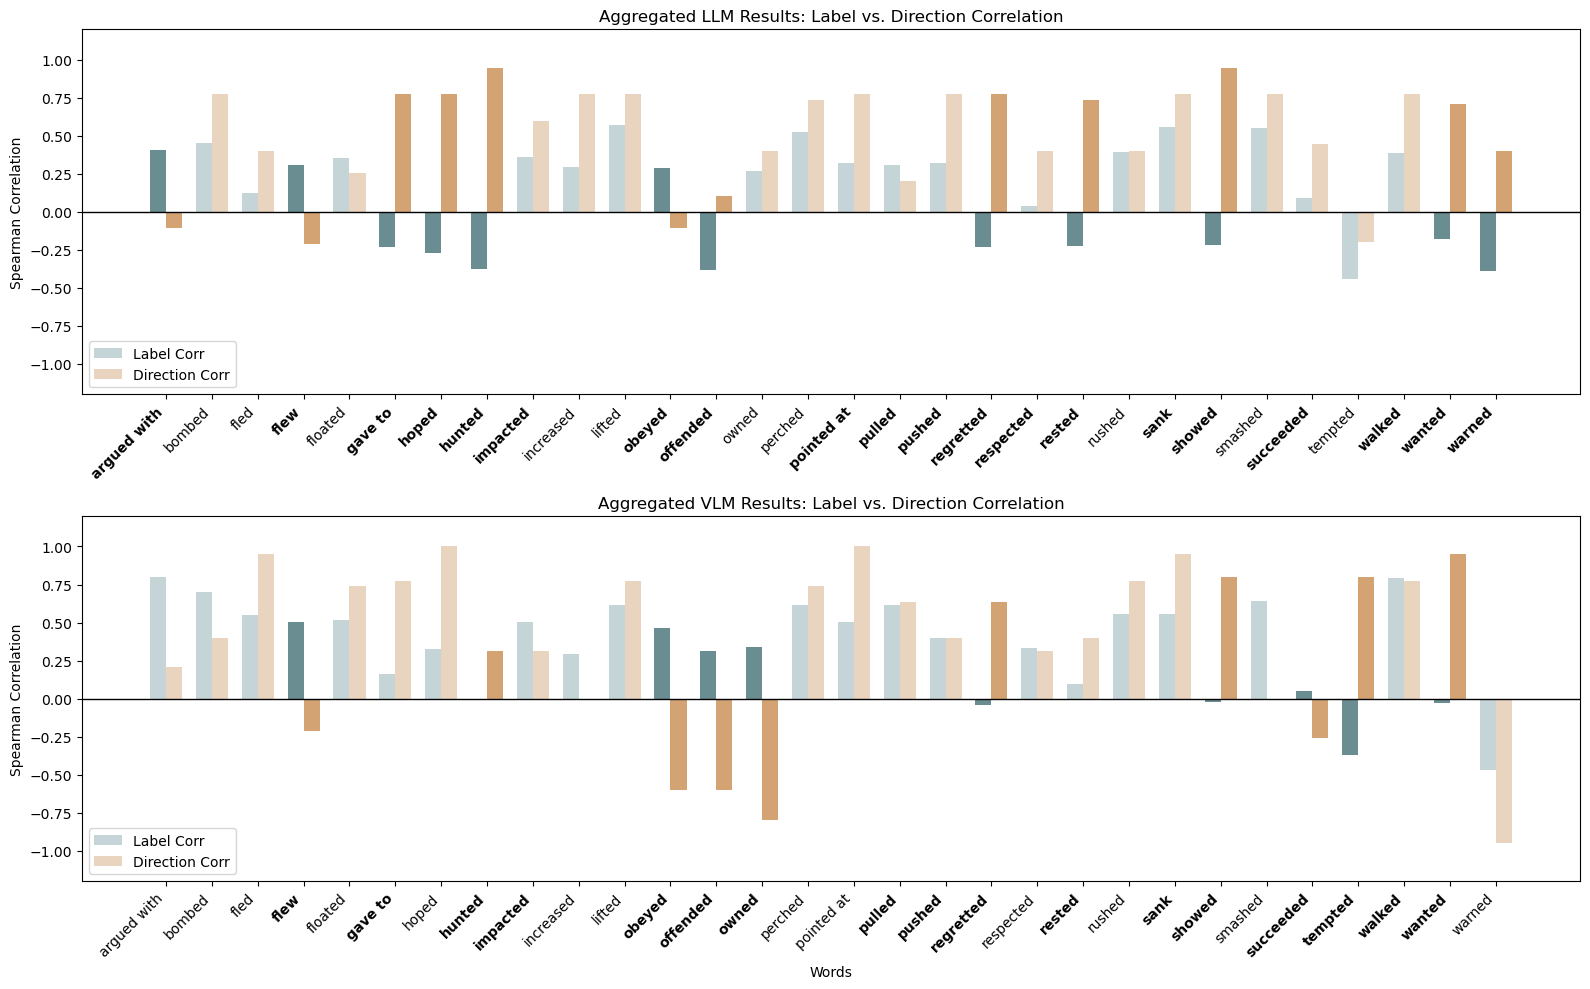

In [56]:
# Assumptions:
# • llm_results: {model_name: {condition: {word: {"spearman": value, ...}, ...}, ...}
# • vlm_results: {model_name: {condition: {word: {"spearman": value, ...}, ...}, ...}
# • llm_dict: {word: {direction: value}} for LLMs 
# • vlm_dict: {word: {direction: value}} for VLMs 
# • hmn_dict: {word: {direction: value}} for human responses 
#
# The set of words is assumed to be common to hmn_dict (and others).
# Directions:
directions = ["up", "down", "left", "right"]

# 1. Aggregate label correlation over all models/conditions for LLMs.
words = sorted(list(hmn_dict.keys()))
aggregated_label_llm = {}
for word in words:
    vals = []
    for model in llm_results:
        for cond in llm_results[model]:
            if word in llm_results[model][cond]:
                vals.append(llm_results[model][cond][word]["spearman"])
    aggregated_label_llm[word] = np.mean(vals) if vals else 0.0

# 2. Aggregate label correlation for VLMs.
aggregated_label_vlm = {}
for word in words:
    vals = []
    for model in vlm_results:
        for cond in vlm_results[model]:
            if word in vlm_results[model][cond]:
                vals.append(vlm_results[model][cond][word]["spearman"])
    aggregated_label_vlm[word] = np.mean(vals) if vals else 0.0

# 3. Compute aggregated directional correlations.
aggregated_direction_llm = {}
for word in words:
    model_vals = [llm_dict[word][d] for d in directions]
    human_vals = [hmn_dict[word][d] for d in directions]
    corr, _ = spearmanr(model_vals, human_vals)
    aggregated_direction_llm[word] = corr if not np.isnan(corr) else 0.0

aggregated_direction_vlm = {}
for word in words:
    model_vals = [vlm_dict[word][d] for d in directions]
    human_vals = [hmn_dict[word][d] for d in directions]
    corr, _ = spearmanr(model_vals, human_vals)
    aggregated_direction_vlm[word] = corr if not np.isnan(corr) else 0.0

# Prepare arrays for plotting.
llm_label_vals = [aggregated_label_llm[word] for word in words]
llm_dir_vals   = [aggregated_direction_llm[word] for word in words]
vlm_label_vals = [aggregated_label_vlm[word] for word in words]
vlm_dir_vals   = [aggregated_direction_vlm[word] for word in words]

# Define colors for light and bold versions (high contrast uses dark colors)
light_label_color = "#C5D4D6"      # Pale Turquoise
bold_label_color  = "#6A8D92"       # Dark Teal
light_direction_color = "#E9D4C0"   # Moccasin (Light Orange)
bold_direction_color  = "#D4A373"    # Dark Orange

bar_width = 0.35
indices = np.arange(len(words))

# Create a figure with two vertically stacked subplots.
fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=False, figsize=(16, 10))

# ----------------------
# Top panel: Aggregated LLM results.
for i, word in enumerate(words):
    lab_val = llm_label_vals[i]
    d_val = llm_dir_vals[i]
    # Use bold colors if the two correlations have opposite signs.
    if lab_val * d_val < 0:
        c_lab, c_dir = bold_label_color, bold_direction_color
    else:
        c_lab, c_dir = light_label_color, light_direction_color
    ax_top.bar(indices[i] - bar_width/2, lab_val, width=bar_width, color=c_lab)
    ax_top.bar(indices[i] + bar_width/2, d_val, width=bar_width, color=c_dir)

ax_top.axhline(0, color='black', linestyle='-', linewidth=1)
ax_top.set_ylim(-1.2, 1.2)
ax_top.set_yticks(np.arange(-1, 1.01, 0.25))
ax_top.set_ylabel("Spearman Correlation")
ax_top.set_title("Aggregated LLM Results: Label vs. Direction Correlation")
ax_top.set_xticks(indices)
ax_top.set_xticklabels(words, rotation=45, ha="right")

# Bold tick labels when there is high contrast.
for i, tick_label in enumerate(ax_top.get_xticklabels()):
    if llm_label_vals[i] * llm_dir_vals[i] < 0:
        tick_label.set_fontweight("bold")

# ----------------------
# Bottom panel: Aggregated VLM results.
for i, word in enumerate(words):
    lab_val = vlm_label_vals[i]
    d_val = vlm_dir_vals[i]
    if lab_val * d_val < 0:
        c_lab, c_dir = bold_label_color, bold_direction_color
    else:
        c_lab, c_dir = light_label_color, light_direction_color
    ax_bot.bar(indices[i] - bar_width/2, lab_val, width=bar_width, color=c_lab)
    ax_bot.bar(indices[i] + bar_width/2, d_val, width=bar_width, color=c_dir)

ax_bot.axhline(0, color='black', linestyle='-', linewidth=1)
ax_bot.set_ylim(-1.2, 1.2)
ax_bot.set_yticks(np.arange(-1, 1.01, 0.25))
ax_bot.set_ylabel("Spearman Correlation")
ax_bot.set_title("Aggregated VLM Results: Label vs. Direction Correlation")
ax_bot.set_xlabel("Words")
ax_bot.set_xticks(indices)
ax_bot.set_xticklabels(words, rotation=45, ha="right")
for i, tick_label in enumerate(ax_bot.get_xticklabels()):
    if vlm_label_vals[i] * vlm_dir_vals[i] < 0:
        tick_label.set_fontweight("bold")

# Bold the x-axis tick labels for words with high contrast in both subplots.
for ax, lab_corr_list, dir_corr_list in [(ax_top, gpt_label_corr, llm_dir_corr_list),
                                           (ax_bot, qwen_label_corr, vlm_dir_corr_list)]:
    for i, label in enumerate(ax.get_xticklabels()):
        if lab_corr_list[i] * dir_corr_list[i] < 0:
            label.set_fontweight("bold")

# Create custom legend handles representing the metrics.
label_patch = mpatches.Patch(color=light_label_color, label="Label Corr")
direction_patch = mpatches.Patch(color=light_direction_color, label="Direction Corr")
ax_top.legend(handles=[label_patch, direction_patch])
ax_bot.legend(handles=[label_patch, direction_patch])


# Add a unified legend (can be added to the bottom subplot).
legend_handles = [
    Patch(facecolor=light_label_color, label="Label Corr"),
    Patch(facecolor=light_direction_color, label="Direction Corr")
]
ax_bot.legend(handles=legend_handles, loc='lower left')
ax_top.legend(handles=legend_handles, loc='lower left')

plt.tight_layout()
plt.savefig('../../data/human_results/figures/correlation_contrast_aggreg.png', dpi=300,bbox_inches='tight')
plt.savefig('../../data/human_results/figures/correlation_contrast_aggreg.pdf', bbox_inches='tight')
plt.show()

In [62]:
import json
from pprint import pprint
path_to_results = "results/analogy_labels/aggregated_label_evaluation.json"

with open(path_to_results, "r") as f:
    res_dict = json.load(f)

pprint(res_dict)

{'LLM': {'gpt': {'pseudo_3.5': {'average_f1': 0.42399612999952835,
                                'average_spearman': 0.14385019694806908},
                 'pseudo_4': {'average_f1': 0.4098933845398107,
                              'average_spearman': 0.13795263814578862},
                 'pseudo_4-mini': {'average_f1': 0.4005816268087683,
                                   'average_spearman': 0.1404343269323677},
                 'text_3.5': {'average_f1': 0.4251356350009574,
                              'average_spearman': 0.16581990419701084},
                 'text_4': {'average_f1': 0.40550815944498814,
                            'average_spearman': 0.11593319185232676},
                 'text_4-mini': {'average_f1': 0.3913163633467981,
                                 'average_spearman': 0.12303151446606636}},
         'llama': {'pseudo_70b': {'average_f1': 0.408123336066774,
                                  'average_spearman': 0.156962621982888},
                   'pseud

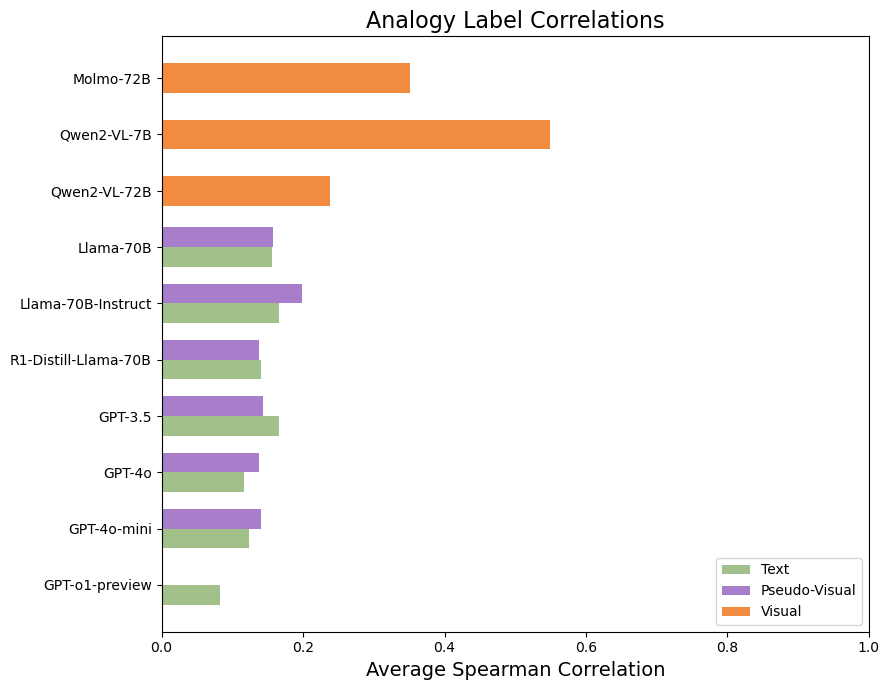

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data extraction from res_dict ---
# (Mapping the average_spearman values to the 10 rows as specified.)

# LLM group (each row: two bars: text and pseudo)
# Row order:
# 1. GPT-o1-preview       (from reasoning)
# 2. GPT-4o-mini          (from gpt: *_4-mini)
# 3. GPT-4o               (from gpt: *_4)         <-- GPT-4 pseudo must be #D4A373
# 4. GPT-3.5              (from gpt: *_3.5)
# 5. R1-Distill-Llama-70B (from llama: r1-llama)
# 6. Llama-70B-Instruct   (from llama: *_70b_inst)
# 7. Llama-70B            (from llama: *_70b)

# For the reasoning category (GPT-o1-preview):
reasoning = res_dict['LLM']['reasoning']
gpt_o1_text    = reasoning['text_o1-preview']['average_spearman']
gpt_o1_pseudo  = reasoning['pseudo_o1-preview']['average_spearman']

# GPT group:
gpt = res_dict['LLM']['gpt']
gpt_4mini_text   = gpt['text_4-mini']['average_spearman']
gpt_4mini_pseudo = gpt['pseudo_4-mini']['average_spearman']

gpt_4_text   = gpt['text_4']['average_spearman']
gpt_4_pseudo = gpt['pseudo_4']['average_spearman']  # Must be #D4A373

gpt_35_text   = gpt['text_3.5']['average_spearman']
gpt_35_pseudo = gpt['pseudo_3.5']['average_spearman']

# Llama group:
llama = res_dict['LLM']['llama']
llama_r1_text   = llama['text_r1-llama']['average_spearman']
llama_r1_pseudo = llama['pseudo_r1-llama']['average_spearman']

llama_inst_text   = llama['text_70b_inst']['average_spearman']
llama_inst_pseudo = llama['pseudo_70b_inst']['average_spearman']

llama_text   = llama['text_70b']['average_spearman']
llama_pseudo = llama['pseudo_70b']['average_spearman']

# Assemble arrays for the 7 LLM rows:
llm_text_vals   = [gpt_o1_text, gpt_4mini_text, gpt_4_text, gpt_35_text,
                   llama_r1_text, llama_inst_text, llama_text]
llm_pseudo_vals = [gpt_o1_pseudo, gpt_4mini_pseudo, gpt_4_pseudo, gpt_35_pseudo,
                   llama_r1_pseudo, llama_inst_pseudo, llama_pseudo]

# VLM group (each row: one bar)
# Order:
# 8. Qwen2-VL-72B  (from qwen-vl, key "-72b")
# 9. Qwen2-VL-7B   (from qwen-vl, key "7b")
# 10. Molmo-72B    (from molmo, key "72b")
qwen   = res_dict['VLM']['qwen-vl']
molmo  = res_dict['VLM']['molmo']

vlm_vals = [
    qwen['-72b']['average_spearman'],  # Qwen2-VL-72B
    qwen['7b']['average_spearman'],     # Qwen2-VL-7B
    molmo['72b']['average_spearman']     # Molmo-72B
]

# Y-axis labels covering all 10 rows:
y_labels = ["GPT-o1-preview", "GPT-4o-mini", "GPT-4o", "GPT-3.5",
            "R1-Distill-Llama-70B", "Llama-70B-Instruct", "Llama-70B",
            "Qwen2-VL-72B", "Qwen2-VL-7B", "Molmo-72B"]

# --- Plotting setup ---
fig, ax = plt.subplots(figsize=(9, 7))

# For the LLM group (rows 0 to 6)
n_llm = len(llm_text_vals)
positions = np.arange(n_llm)  # positions from 0 to 6
bar_height = 0.35  # height for each bar; we’ll offset the paired bars
offset = bar_height / 2

# NEW PALETTE:
# • LLM text bars: a muted pastel sage-green
# • LLM pseudo bars: set to #D4A373 (warm pastel mustard); note GPT-4 pseudo remains as required.
# • VLM single bars: a soft pastel lilac.
llm_text_color = "#A1C08A"
llm_pseudo_color = "#A87DC9" 
vlm_color = "#F08B40"

# Plot LLM bars (horizontal grouped bars)
ax.barh(positions - offset, llm_text_vals, height=bar_height,
        color=llm_text_color, label="Text")
ax.barh(positions + offset, llm_pseudo_vals, height=bar_height,
        color=llm_pseudo_color, label="Pseudo-Visual")

# For the VLM group, position them after the LLM rows:
vlm_positions = np.arange(n_llm, n_llm + len(vlm_vals))
ax.barh(vlm_positions, vlm_vals, height=bar_height*1.5, color=vlm_color, label="Visual")

# Set y-ticks to cover all 10 rows:
all_positions = np.concatenate([positions, vlm_positions])
ax.set_yticks(all_positions)
ax.set_yticklabels(y_labels)
ax.set_xlim([0,1])

# Title and axes labels
ax.set_title("Analogy Label Correlations", fontsize=16)
ax.set_xlabel("Average Spearman Correlation", fontsize=14)

# Add legend (avoid duplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="lower right")

# Tight layout for clarity
plt.tight_layout()
plt.savefig('../../data/human_results/figures/correlation_analogies.png', dpi=300,bbox_inches='tight')
plt.savefig('../../data/human_results/figures/correlation_analogies.pdf', bbox_inches='tight')
plt.show()